In [1]:
import os

import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

import mgitools.os_helpers as os_helpers

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# !pip install git+https://github.com/estorrs/mgitools

In [4]:
figdir = '../results/cptac_f2f_presentation_05242021'
from pathlib import Path
Path(figdir).mkdir(parents=True, exist_ok=True)

#### read in data

In [9]:
d = pd.read_csv('../data/199_driver_genes.txt', sep='\t')
d

,Gene,Tumor suppressor or oncogene prediction (by 20/20+)
0,PHF6,possible tsg
1,ABL1,NaN
2,ALK,NaN
3,AR,NaN
4,ARAF,NaN
...,...,...
183,KMT2A,tsg
184,KMT2B,tsg
185,MAX,oncogene
186,MED12,oncogene


In [10]:
target_genes = ['PIK3CA', 'TP53', 'KRAS']
target_genes = sorted(set(d['Gene']))

###### protein pairs

In [11]:
# get pik3ca related genes
pathways = pd.read_csv('../data/protein_pair_table_v2.txt', sep='\t')
pathways

,GENE,SUB_GENE,pair_pro,SUB_GENE.is_TF_downstream,SUB_GENE.is_TF_upstream,SUB_GENE.is_kinase_substrate,SUB_GENE.is_phosphatase_substrate,SUB_GENE.is_upstream_kinase,SUB_GENE.is_upstream_phosphatase,SUB_GENE.is_complex_partner
0,TP53,CDKN1A,TP53:CDKN1A,True,False,False,False,False,False,False
1,TP53,SIAH1,TP53:SIAH1,True,False,False,False,False,False,False
2,TP53,SFN,TP53:SFN,True,False,False,False,False,False,False
3,TP53,RPRM,TP53:RPRM,True,False,False,False,False,False,False
4,TP53,GADD45A,TP53:GADD45A,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
831929,SETD2,SETD2,SETD2:SETD2,False,False,False,False,False,False,False
831930,PUMA,PUMA,PUMA:PUMA,False,False,False,False,False,False,False
831931,NOXA,NOXA,NOXA:NOXA,False,False,False,False,False,False,False
831932,FOXR2,FOXR2,FOXR2:FOXR2,False,False,False,False,False,False,False


In [12]:
pathways[[True if g in target_genes else False
         for g in pathways['GENE']]]

,GENE,SUB_GENE,pair_pro,SUB_GENE.is_TF_downstream,SUB_GENE.is_TF_upstream,SUB_GENE.is_kinase_substrate,SUB_GENE.is_phosphatase_substrate,SUB_GENE.is_upstream_kinase,SUB_GENE.is_upstream_phosphatase,SUB_GENE.is_complex_partner
0,TP53,CDKN1A,TP53:CDKN1A,True,False,False,False,False,False,False
1,TP53,SIAH1,TP53:SIAH1,True,False,False,False,False,False,False
2,TP53,SFN,TP53:SFN,True,False,False,False,False,False,False
3,TP53,RPRM,TP53:RPRM,True,False,False,False,False,False,False
4,TP53,GADD45A,TP53:GADD45A,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
830817,IDH1,IDH1,IDH1:IDH1,False,False,False,False,False,False,False
831488,BCOR,BCOR,BCOR:BCOR,False,False,False,False,False,False,False
831552,ATRX,ATRX,ATRX:ATRX,False,False,False,False,False,False,False
831798,RQCD1,RQCD1,RQCD1:RQCD1,False,False,False,False,False,False,False


In [13]:
gene_to_subgenes = {t:[g for g in sorted(set(pathways[pathways['GENE']==t]['SUB_GENE'])) if g != t]
                    for t in target_genes}
target_genes[0], len(gene_to_subgenes[target_genes[0]])

('ABL1', 126)

###### proteome

In [16]:
proteome = pd.read_csv('../data/Combine_PanCan_Proteome-gene_UMich_GENCODE34_Sinai_imputed_Apr2021.tsv',
                      sep='\t')
genes = proteome['GENECODE34_Symbol'].to_list()
proteome = proteome.iloc[:, 2:].transpose()
proteome.columns = genes
proteome['sample_id'] = proteome.index.to_list()
# proteome['sample_id'] = [x[1:] if 'CO' in x else x for x in proteome.index]
proteome = proteome.set_index('sample_id')
# scale
# proteome = pd.DataFrame(data=StandardScaler().fit_transform(proteome.values),
#                  columns=proteome.columns, index=proteome.index)
proteome

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,NIPAL3,...,EXOC3L2,PRR33,SCO2,AC073111.4,EEF1AKMT4,CCDC39,AL022312.1,AL034430.2,ASDURF,DERPC
sample_id,,,,,,,,,,,,,,,,,,,,,
01BR001-T,21.421546,25.896035,24.095342,NaN,20.374201,29.558080,24.189202,26.081010,23.426992,21.618669,...,21.324716,NaN,24.842217,NaN,19.880139,NaN,22.625876,22.513445,22.429392,24.813732
01BR008-T,22.334792,26.046587,23.921620,NaN,20.979104,28.528723,24.044621,25.587332,23.569577,21.696055,...,21.088402,NaN,24.676147,NaN,19.573110,NaN,22.026176,22.115323,22.451728,24.206633
01BR009-T,22.744050,25.816690,23.955057,NaN,20.532495,29.716976,24.095790,25.449831,23.190233,22.091323,...,21.125166,NaN,25.664726,NaN,19.980938,NaN,21.849140,22.642879,22.171134,23.905527
01BR010-T,25.040285,26.641993,24.509677,NaN,19.948534,29.157457,24.202489,25.862581,23.053010,21.838931,...,21.463939,NaN,24.755041,NaN,20.019758,NaN,22.313802,22.922275,22.334238,23.527194
01BR015-T,21.159464,26.076153,23.829427,NaN,19.626148,29.658244,24.290514,25.589347,23.559853,20.858738,...,20.826410,NaN,24.584503,NaN,19.598232,NaN,22.645138,22.657004,22.661953,24.564202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QC4-Q.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QC5-Q.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QC6-Q.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
[x for x in proteome.index if 'CO' in x][:2]

['01CO005-T', '01CO006-T']

In [18]:
genes = []
for target_gene, subgenes in gene_to_subgenes.items():
    genes += [target_gene]
    genes += subgenes
genes = sorted(set(genes))
proteome = proteome[[g for g in genes if g in proteome.columns]]
proteome.columns = [f'{c}_proteome' for c in proteome.columns]
proteome

,AAAS_proteome,AAK1_proteome,AATF_proteome,ABCA1_proteome,ABCA2_proteome,ABCB1_proteome,ABCB11_proteome,ABCC2_proteome,ABCC3_proteome,ABCE1_proteome,...,ZNRF2_proteome,ZRSR2_proteome,ZSCAN10_proteome,ZSCAN25_proteome,ZSCAN32_proteome,ZW10_proteome,ZWILCH_proteome,ZWINT_proteome,ZXDC_proteome,ZYX_proteome
sample_id,,,,,,,,,,,,,,,,,,,,,
01BR001-T,24.366478,24.512335,25.009167,22.761127,18.747711,NaN,NaN,NaN,19.982433,26.985937,...,23.783368,20.954146,NaN,NaN,NaN,25.160244,22.453169,21.101127,21.230329,28.397691
01BR008-T,24.394392,24.336012,25.198883,22.507570,19.817547,NaN,NaN,NaN,19.608661,26.724760,...,23.756042,21.549888,NaN,NaN,NaN,25.341950,22.635411,21.522846,20.922012,27.935289
01BR009-T,24.126891,24.312230,24.822895,23.841045,20.841777,NaN,NaN,NaN,19.515286,26.398394,...,24.313472,21.568350,NaN,NaN,NaN,25.264645,22.073689,20.996493,20.274014,28.101657
01BR010-T,24.328566,24.399937,24.455721,23.044677,20.980193,NaN,NaN,NaN,20.429545,26.360272,...,23.565525,21.385798,NaN,NaN,NaN,25.825940,21.441472,20.719015,19.688179,28.634480
01BR015-T,24.606059,24.330728,24.259055,22.052379,19.149462,NaN,NaN,NaN,18.981616,26.545160,...,23.291041,21.142830,NaN,NaN,NaN,25.124026,21.907613,21.629653,18.811849,28.760563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QC4-Q.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QC5-Q.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QC6-Q.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### purity

In [19]:
purity = pd.read_csv('../data/CPTAC_pancan_RNA_tumor_purity_ESTIMATE.tsv.gz',
                    sep='\t')
purity['sample_id'] = purity['Sample_ID'].to_list()
purity = purity.set_index('sample_id')
purity = purity[['TumorPurity']]
purity

,TumorPurity
sample_id,
01BR001-T,0.816624
01BR008-T,0.510466
01BR009-T,0.556239
01BR010-T,0.747700
01BR015-T,0.649161
...,...
C3N-01520-T,0.869669
C3N-01521-T,0.855558
C3N-01537-T,0.647919


###### somatic mutation

In [44]:
fps = sorted(os_helpers.listfiles('../data/Somatic_mutation_wxs/', regex=r'exonic.*.maf.gz$'))
fps = [fp for fp in fps if 'Archived' not in fp]
fps

['../data/Somatic_mutation_wxs/BR/WashU_pipeline/BR_prospective.dnp.annotated.exonic.addrecovercases.maf.gz',
 '../data/Somatic_mutation_wxs/CO/WashU_pipeline/CO_prospective.dnp.annotated.exonic.addrecovercases.maf.gz',
 '../data/Somatic_mutation_wxs/EC/WashU_pipeline/EC_discovery.dnp.annotated.exonic.maf.gz',
 '../data/Somatic_mutation_wxs/GBM/WashU_pipeline/GBM_discovery.dnp.annotated.exonic.maf.gz',
 '../data/Somatic_mutation_wxs/HNSCC/WashU_pipeline/HNSCC_discovery.dnp.annotated.exonic.maf.gz',
 '../data/Somatic_mutation_wxs/LSCC/WashU_pipeline/LSCC_discovery.dnp.annotated.exonic.maf.gz',
 '../data/Somatic_mutation_wxs/LUAD/WashU_pipeline/LUAD_discovery.dnp.annotated.exonic.maf.gz',
 '../data/Somatic_mutation_wxs/OV/WashU_pipeline/OV_prospective.dnp.annotated.exonic.addrecovercases.maf.gz',
 '../data/Somatic_mutation_wxs/PDA/WashU_pipeline/PDA_discovery.dnp.annotated.exonic.maf.gz',
 '../data/Somatic_mutation_wxs/ccRCC/WashU_pipeline/ccRCC_discovery.dnp.annotated.exonic.maf.gz']

In [45]:
mutations = None
genes = list(target_genes)
for gs in gene_to_subgenes.values(): genes += gs
genes = sorted(set(genes))
keep = ['gene', 'sample_id', 'Chromosome', 'Start_Position', 'End_Position', 'HGVSp_Short', 'Variant_Classification']
for fp in fps:
    cancer_type = fp.split('/')[-1].split('_')[0]
    df = pd.read_csv(fp, sep='\t')
    df = df.loc[[True if g in genes else False for g in df['Hugo_Symbol']]]
    df = df[df['Variant_Classification']!='Silent']
    df['sample_id'] = [x.replace('_', '-') for x in df['Tumor_Sample_Barcode']]
    df['gene'] = df['Hugo_Symbol'].to_list()
    df = df[keep]
    df['disease'] = cancer_type
    
    
    if mutations is None:
        mutations = df
    else:
        mutations = pd.concat((mutations, df), axis=0)

Columns (88) have mixed types.Specify dtype option on import or set low_memory=False.


In [46]:
mutations

,gene,sample_id,Chromosome,Start_Position,End_Position,HGVSp_Short,Variant_Classification,disease
0,PIK3CD,01BR001-T,chr1,9722533,9722533,p.R785W,Missense_Mutation,BR
5,HECW2,01BR001-T,chr2,196319047,196319047,p.E615K,Missense_Mutation,BR
10,AREG,01BR001-T,chr4,74445388,74445388,p.L15F,Missense_Mutation,BR
11,SCLT1,01BR001-T,chr4,129044011,129044011,p.N48S,Missense_Mutation,BR
12,FBXW7,01BR001-T,chr4,152329731,152329731,p.R393*,Nonsense_Mutation,BR
...,...,...,...,...,...,...,...,...
7671,KDM5C,C3N-01651-T,chrX,53201570,53201570,p.R681*,Nonsense_Mutation,ccRCC
7677,HMCN1,C3N-01808-T,chr1,186053964,186053965,p.E2281Ifs*8,Frame_Shift_Del,ccRCC
7686,SGK1,C3N-01808-T,chr6,134172758,134172758,p.Q284R,Missense_Mutation,ccRCC
7693,LRP5,C3N-01808-T,chr11,68348050,68348050,p.V99L,Missense_Mutation,ccRCC


In [47]:
from collections import Counter
c = Counter(mutations['Variant_Classification'])
c

Counter({'Missense_Mutation': 45577,
         'Nonsense_Mutation': 4341,
         'Frame_Shift_Del': 5236,
         'Splice_Site': 1658,
         'In_Frame_Del': 495,
         'In_Frame_Ins': 83,
         'Nonstop_Mutation': 82,
         'Frame_Shift_Ins': 1291})

In [23]:
# import re
# windows = {'PI3K_p85B': (32, 107), 'PI3K_rbd': (173, 292), 'C2_PI3K_class_I_alpha': (325, 484),
#            'PI3Ka_I': (525, 694), 'PI3Kc_IA_alpha': (695, 1064),
#           'p110alpha-p85alpha complex': (345, 345)}
# for k, (s, e) in windows.items():
#     ls = []
#     for x in mutations['HGVSp_Short']:
#         loc = int(re.sub(r'^p.[A-Z\*]([0-9]+)[^0-9]+.*$', r'\1', x))
#         ls.append(1 if loc >= s and loc <= e else 0)
#     mutations[f'in_{k}'] = ls
# mutations

In [ ]:
# do mutation type columns
# d = {x:i for i, x in sorted(set(mutations['Variant_Classification']))}
types = sorted(set(mutations['Variant_Classification']))
for gene in genes:
    print(gene)
    for m in types:
        mutations[f'{gene}_mutation_is_{m}'] = [1 if vc==m and g==gene else 0
                        for vc, g in zip(mutations['Variant_Classification'], mutations['gene'])]
    mutations[f'{gene}_frameshift_mutation'] = [1 if 'Shift' in vc and g==gene else 0
                    for vc, g in zip(mutations['Variant_Classification'], mutations['gene'])]
    mutations[f'{gene}_is_mutated'] = [1 if g==gene else 0
                    for g in mutations['gene']]
mutations

AAAS
AAK1
AATF
ABCA1
ABCA2
ABCB1
ABCB11
ABCC2
ABCC3
ABCE1
ABCF2
ABCG2
ABI1
ABI2
ABL1
ABL2
ABLIM1
ABLIM2
ABLIM3
ABRAXAS1
ACAD10
ACAD8
ACAP1
ACD
ACIN1
ACLY
ACOT2
ACOT4
ACOT8
ACOX1
ACOX2
ACOX3
ACP1
ACPP
ACTA2
ACTB
ACTG1
ACTG2
ACTL6A
ACTL6B
ACTN1
ACTR1A
ACTR2
ACTR3
ACVR1C
ADA
ADAM10
ADAM17
ADCY1
ADCY2
ADCY3
ADCY4
ADCY5
ADCY6
ADCY7
ADCY8
ADCY9
ADCYAP1
ADCYAP1R1
ADGRG1
ADH1B
ADM
ADM2


In [ ]:
sample_ids = sorted(set(mutations['sample_id']))
new = []
for s in sample_ids:
    filtered = mutations[mutations['sample_id']==s]
    base = filtered.iloc[0, :7].to_list()
#     base = filtered[['sample_id', 'disease']].iloc[0]
    if filtered.shape[0]<=1:
        tail = filtered.iloc[0, 7:].to_list()
    else:
        tail = list(np.max(filtered.iloc[:, 7:].values, axis=0).flatten())
    ls = base + tail
    new.append(ls)
consolidated = pd.DataFrame(data=new, index=sample_ids, columns=mutations.columns)
consolidated

In [ ]:
consolidated = consolidated.set_index('sample_id')

In [ ]:
consolidated_filtered = consolidated.iloc[:, 7:]
# consolidated_filtered = consolidated
consolidated_filtered

###### somatic cnv

In [ ]:
fps = sorted(os_helpers.listfiles('../data/Somatic_cnv/', regex=r'WashU_pipeline_wxs/'))
fps = [fp for fp in fps if 'gene_level' in fp]
fps

In [ ]:
cnv = None
gene_order = list(set(pd.read_csv(fps[0], sep='\t')['Gene']).intersection(*[set(pd.read_csv(fp, sep='\t')['Gene'])
                                                                           for fp in fps[1:]]))
for fp in fps:
    df = pd.read_csv(fp,
                sep='\t')
    df = df.set_index('Gene')
    df = df.transpose()[gene_order]
    df['disease'] = fp.split('/')[3]
    
    if cnv is None:
        cnv = df
    else:
        cnv = pd.concat((cnv, df), axis=0)
cnv

In [ ]:
include = [g for g in target_genes]
for gs in gene_to_subgenes.values(): include += gs
include = sorted(set(include))
include.append('disease')

cnv = cnv[[g for g in include if g in cnv.columns]]
cnv.columns = [f'{c}_cnv' if c!='disease' else c for c in cnv.columns]
cnv.index = [x + '-T' for x in cnv.index]
cnv

###### eQTL

In [23]:
fps = sorted(os_helpers.listfiles('../data/Somatic_mutation_wxs/', regex=r'exonic.*.maf.gz$'))
fps = [fp for fp in fps if 'Archived' not in fp]
mutations = None
genes = list(target_genes)
for gs in gene_to_subgenes.values(): genes += gs
genes = sorted(set(genes))
keep = ['gene', 'sample_id', 'Chromosome', 'Start_Position', 'End_Position', 'HGVSp_Short', 'Variant_Classification',
       'Reference_Allele', 'Tumor_Seq_Allele2']
for fp in fps:
    cancer_type = fp.split('/')[-1].split('_')[0]
    df = pd.read_csv(fp, sep='\t')
    df = df.loc[[True if g in genes else False for g in df['Hugo_Symbol']]]
#     df = df[df['Variant_Classification']!='Silent']
    df['sample_id'] = [x.replace('_', '-') for x in df['Tumor_Sample_Barcode']]
    df['gene'] = df['Hugo_Symbol'].to_list()
    df = df[keep]
    df['disease'] = cancer_type
    
    
    if mutations is None:
        mutations = df
    else:
        mutations = pd.concat((mutations, df), axis=0)

Columns (88) have mixed types.Specify dtype option on import or set low_memory=False.


In [63]:
mutations

,gene,sample_id,Chromosome,Start_Position,End_Position,HGVSp_Short,Variant_Classification,Reference_Allele,Tumor_Seq_Allele2,disease
0,PIK3CD,01BR001-T,chr1,9722533,9722533,p.R785W,Missense_Mutation,C,T,BR
10,AREG,01BR001-T,chr4,74445388,74445388,p.L15F,Missense_Mutation,C,T,BR
12,FBXW7,01BR001-T,chr4,152329731,152329731,p.R393*,Nonsense_Mutation,G,A,BR
34,FLT1,01BR001-T,chr13,28438252,28438252,p.T161M,Missense_Mutation,G,A,BR
43,TP53,01BR001-T,chr17,7674216,7674216,p.R249S,Missense_Mutation,C,A,BR
...,...,...,...,...,...,...,...,...,...,...
7641,PTEN,C3N-01651-T,chr10,87933033,87933033,p.D92Y,Missense_Mutation,G,T,ccRCC
7655,IGHG2,C3N-01651-T,chr14,105644096,105644096,p.K101Nfs*31,Frame_Shift_Del,T,-,ccRCC
7673,TP73,C3N-01808-T,chr1,3731054,3731054,p.P491P,Silent,C,T,ccRCC
7683,FGB,C3N-01808-T,chr4,154563025,154563025,p.R3R,Silent,A,C,ccRCC


In [64]:
fps = sorted(os_helpers.listfiles('/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered',
                                 ))
fps

['/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/BR_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/CO_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/EC_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/GBM_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/HNSCC_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/LSCC_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/LUAD_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/OV_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/PDA_eQTLs_filtered.2021017.tsv',
 '/diskmnt/Projects/Users/estorrs/cptac_driver/data/eQTL_filtered/ccRCC_eQTLs_filtered.2021017.tsv']

In [65]:
eqtl = None

for fp in fps:
    df = pd.read_csv(fp,
                sep='\t')
    
    if eqtl is None:
        eqtl = df
    else:
        eqtl = pd.concat((eqtl, df), axis=0)
eqtl

,SNP,gene,beta,t.stat,P,FDR,Gene_SNP,Disease
0,chr1_107056636_A_T,PRMT6,-0.606306,-5.163265,1.373427e-06,2.883696e-02,PRMT6,BR
1,chr1_109656105_C_G,GSTM4,-0.574039,-5.391549,5.270820e-07,1.706793e-02,GSTM4,BR
2,chr1_109688145_G_A,GSTM1,0.676938,8.537473,2.526182e-13,1.709479e-06,GSTM1,BR
3,chr1_109690179_A_G,GSTM1,0.707850,9.033014,2.272933e-14,1.644163e-07,GSTM1,BR
4,chr1_109690625_T_C,GSTM1,0.611524,7.463626,4.401857e-11,4.542680e-05,GSTM1,BR
...,...,...,...,...,...,...,...,...
4914,chr9_92784607_G_A,ASPN,3.278481,5.040561,2.460206e-06,4.897364e-02,ASPN,ccRCC
4915,chr9_93697213_C_A,FGD3,1.352675,5.120912,1.774278e-06,4.078420e-02,FGD3,ccRCC
4916,chr9_93849832_C_G,FGD3,2.705351,5.120912,1.774278e-06,4.078420e-02,FGD3,ccRCC
4917,chr9_97896656_A_G,TMOD1,-1.901571,-4.773050,7.169601e-06,8.226812e-02,TMOD1,ccRCC


In [66]:
for disease in set(eqtl['Disease']):
    sites = set(eqtl[eqtl['Disease']==disease]['SNP'])
    f = mutations[mutations['disease']==disease]
    mask = [True if f'{c}_{s}_{ref}_{alt}' in sites else False
           for c, s, ref, alt in zip(f['Chromosome'], f['Start_Position'],
                                    f['Reference_Allele'], f['Tumor_Seq_Allele2'])]
    print(f[mask].shape)

(1, 10)
(0, 10)
(0, 10)
(0, 10)
(0, 10)
(0, 10)
(0, 10)
(0, 10)
(0, 10)
(0, 10)


In [ ]:
d = pd.read_csv('../data/199_driver_genes.txt', sep='\t')
d

In [51]:
set(d['Gene']).intersection(mutations[mask]['gene'])

{'ERBB2'}

###### pQTL

In [52]:
pqtl = pd.read_csv('../data/filtered_pQTL.tsv', sep='\t')
pqtl

,SNP,gene,beta,t.stat,P,FDR,Gene_SNP,Disease
0,chr1_109688145_G_A,GSTM1,0.547301,5.611051,2.296727e-07,0.022047,GSTM1,ccRCC
1,chr1_109690179_A_G,GSTM1,0.547301,5.611051,2.296727e-07,0.022047,GSTM1,ccRCC
2,chr1_109690625_T_C,GSTM1,0.547301,5.611051,2.296727e-07,0.022047,GSTM1,ccRCC
3,chr1_109737199_C_A,GSTM3,0.641189,5.217990,1.191517e-06,0.053193,GSTM3,ccRCC
4,chr1_109739319_G_A,GSTM3,0.713888,5.903624,6.529679e-08,0.009406,GSTM3,ccRCC
...,...,...,...,...,...,...,...,...
8195,chr9_137103590_C_T,UAP1L1,-0.585547,-4.871726,6.120846e-06,0.093298,UAP1L1,EC
8196,chr9_21816759_G_A,MTAP,-0.569130,-5.338531,9.881701e-07,0.041168,MTAP,EC
8197,chr9_34318291_G_T,NUDT2,0.948056,6.126573,3.972724e-08,0.008367,NUDT2,EC
8198,chr9_34371790_A_T,NUDT2,0.952703,6.324868,1.732983e-08,0.004470,NUDT2,EC


In [53]:
sites = set(pqtl['SNP'])
mask = [True if f'{c}_{s}_{ref}_{alt}' in sites else False
       for c, s, ref, alt in zip(mutations['Chromosome'], mutations['Start_Position'],
                                mutations['Reference_Allele'], mutations['Tumor_Seq_Allele2'])]
mutations[mask]

,gene,sample_id,Chromosome,Start_Position,End_Position,HGVSp_Short,Variant_Classification,Reference_Allele,Tumor_Seq_Allele2,disease


###### germline_variants

In [ ]:
fps = sorted(os_helpers.listfiles('/diskmnt/Projects/Users/estorrs/cptac_driver/data/Germline_pathogenic_variants_reviewed.1.0/',
                                 ))
fps

In [ ]:
germline = None

for fp in fps:
    df = pd.read_csv(fp,
                sep='\t')
    
    if germline is None:
        germline = df
    else:
        germline = pd.concat((germline, df), axis=0)
germline

In [ ]:
gs = list(target_genes)
for ls in gene_to_subgenes.values(): gs += ls
gs = sorted(set(gs))
mask = [True if g in gs else False
       for g in germline['HUGO_Symbol']]
germline = germline[mask]

In [ ]:
# do mutation type columns
# d = {x:i for i, x in sorted(set(mutations['Variant_Classification']))}
for gene in gs:
    germline[f'{gene}_is_pathogenic_germline'] = [1 if g==gene else 0
                    for g in germline['HUGO_Symbol']]
germline

In [ ]:
germline.index = [x.replace('.N', '') + '-T' for x in germline['Sample']]
germline.index.name = 'sample_id'
germline


In [ ]:
germline = germline[[c for c in germline.columns if 'is_pathogenic_germline' in c]]
germline

In [ ]:
sample_ids = sorted(set(germline.index))
new = []
for s in sample_ids:
    filtered = germline.loc[[s], :]
#     print(filtered.shape)
    if filtered.shape[0]<=1:
        tail = filtered.iloc[0, :].to_list()
    else:
        tail = list(np.max(filtered.values, axis=0).flatten())
#     print(tail)
    new.append(tail)
consolidated_germline = pd.DataFrame(data=new, index=sample_ids, columns=germline.columns)
consolidated_germline

###### rna expression

In [ ]:
expression = pd.read_csv('../data/ALL_RNA-Seq_Expr_WashU_FPKM_UQ.tsv.gz', sep='\t')
expression

In [ ]:
expression = expression[[c for c in expression.columns if c != 'gene_id']]
expression['gene_name'] = [x.split('.')[0] for x in expression['gene_name']]
expression = expression.groupby('gene_name').mean()

expression = expression.transpose()

In [ ]:
expression.columns = [f'{c}_expression' for c in expression.columns]
expression

In [ ]:
## check for IDs
diseases = sorted(set(cnv['disease']))
for d in diseases:
    idxs = cnv[cnv['disease']==d].index.to_list()
    print(d, len(set(idxs).intersection(set(expression.index))))

###### merge everything together

In [ ]:
# merge proteome and mutations
data, idxs = [], []
for s, row in proteome.iterrows():
    if '-T' in s:
        idxs.append(s)
        ls = []
        if s in consolidated_filtered.index:
            ls += consolidated_filtered.loc[s, :].to_list()
        else:
            ls += [0 for i in range(consolidated_filtered.shape[1])]
        
        if s in consolidated_germline.index:
            ls += consolidated_germline.loc[s, :].to_list()
        else:
            ls += [0 for i in range(consolidated_germline.shape[1])]
            
        data.append(ls)
        
cols = list(consolidated_filtered.columns)
cols += list(consolidated_germline.columns)
df = pd.DataFrame(data=data, index=idxs, columns=cols)
df.index.name = 'sample_id'
df

In [ ]:
combined = pd.merge(proteome, df, left_index=True, right_index=True, how='right')
combined

In [ ]:
# list(cnv.index)

In [ ]:
combined = pd.merge(combined, purity, left_index=True, right_index=True, how='left')
combined

In [ ]:
combined = pd.merge(combined, cnv, left_index=True, right_index=True, how='left')
combined

In [ ]:
combined = pd.merge(combined, expression, left_index=True, right_index=True, how='left')
combined

In [50]:
from collections import Counter
Counter(combined['disease'])

Counter({'BR': 120,
         nan: 185,
         'ccRCC': 110,
         'CO': 96,
         'GBM': 99,
         'HNSCC': 110,
         'LUAD': 110,
         'OV': 82,
         'EC': 95,
         'LSCC': 108,
         'PDA': 140})

In [51]:
combined.to_csv('../data/aggregated_05242021.txt.gz', sep='\t', )

In [5]:
combined = pd.read_csv('../data/aggregated_05242021.txt.gz', sep='\t')
combined

Columns (60411) have mixed types.Specify dtype option on import or set low_memory=False.


,sample_id,AAAS_proteome,AAK1_proteome,AATF_proteome,ABCA1_proteome,ABCA2_proteome,ABCB1_proteome,ABCB11_proteome,ABCC2_proteome,ABCC3_proteome,...,snoU2-30_expression,snoU2_19_expression,snoU83B_expression,snoZ196_expression,snoZ278_expression,snoZ40_expression,snoZ6_expression,snosnR66_expression,uc_338_expression,yR211F11_expression
0,01BR001-T,24.366478,24.512335,25.009167,22.761127,18.747711,NaN,NaN,NaN,19.982433,...,8605.851979,15060.240964,0.0,0.000000,0.0,0.0,0.000000,0.0,3064.642802,0.000000
1,01BR008-T,24.394392,24.336012,25.198883,22.507570,19.817547,NaN,NaN,NaN,19.608661,...,7100.255609,6212.723658,0.0,11168.941408,0.0,0.0,0.000000,0.0,4058.372741,0.000000
2,01BR009-T,24.126891,24.312230,24.822895,23.841045,20.841777,NaN,NaN,NaN,19.515286,...,0.000000,3147.029204,0.0,56575.805922,0.0,0.0,0.000000,0.0,2113.866719,3472.583950
3,01BR010-T,24.328566,24.399937,24.455721,23.044677,20.980193,NaN,NaN,NaN,20.429545,...,0.000000,0.000000,0.0,10683.104403,0.0,0.0,0.000000,0.0,4642.228707,1639.303952
4,01BR015-T,24.606059,24.330728,24.259055,22.052379,19.149462,NaN,NaN,NaN,18.981616,...,6916.346786,3025.901719,0.0,0.000000,0.0,0.0,3185.159704,0.0,5415.098490,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,C3N-04119-T,22.997202,24.726521,25.304842,23.719660,NaN,22.479719,NaN,NaN,24.267079,...,184418.855703,257792.821159,0.0,14151.076897,0.0,0.0,0.000000,0.0,27939.784060,0.000000
1251,C3N-04126-T,23.057493,24.772949,25.715299,24.214258,NaN,22.003800,NaN,NaN,24.271196,...,161899.622234,178764.166217,0.0,12127.312527,0.0,0.0,0.000000,0.0,32286.339696,0.000000
1252,C3N-04282-T,22.775772,24.852962,25.724592,23.073272,NaN,21.588377,NaN,NaN,24.725779,...,163576.881134,131202.290076,0.0,0.000000,0.0,0.0,0.000000,0.0,25094.804189,0.000000
1253,C3N-04283-T,23.116111,24.664143,25.571772,23.463646,NaN,21.701678,NaN,NaN,24.395560,...,316347.982781,297827.610371,0.0,44093.446611,0.0,0.0,0.000000,0.0,30913.044407,2899.741440


In [6]:
sns.countplot(combined[~pd.isnull(combined['disease'])].sort_values('disease')['disease'])
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'sample_countplot.pdf'))

NameError: name 'sns' is not defined

In [ ]:
# example TP53


#### train ols

In [ ]:
combined = pd.read_csv('../data/aggregated_06162021.txt.gz', sep='\t')
combined

In [ ]:
combined.columns

In [55]:
{'_'.join(x.split('_')[1:]) for x in combined.columns if 'expression' not in x}

{'',
 'cnv',
 'frameshift_mutation',
 'is_mutated',
 'is_pathogenic_germline',
 'mutation_is_Frame_Shift_Del',
 'mutation_is_Frame_Shift_Ins',
 'mutation_is_In_Frame_Del',
 'mutation_is_In_Frame_Ins',
 'mutation_is_Missense_Mutation',
 'mutation_is_Nonsense_Mutation',
 'mutation_is_Nonstop_Mutation',
 'mutation_is_Splice_Site',
 'proteome'}

In [43]:
target_genes

['ABL1',
 'AJUBA',
 'AKT1',
 'ALB',
 'ALK',
 'AMER1',
 'APC',
 'AR',
 'ARAF',
 'ARHGAP35',
 'ARID1A',
 'ARID2',
 'ASXL1',
 'ASXL2',
 'ATM',
 'ATRX',
 'AXIN1',
 'AXIN2',
 'B2M',
 'BAP1',
 'BCL2',
 'BCOR',
 'BRAF',
 'BRCA1',
 'BRD7',
 'CASP8',
 'CCND1',
 'CD79B',
 'CDH1',
 'CDK12',
 'CDK4',
 'CDKN1A',
 'CDKN1B',
 'CDKN2A',
 'CDKN2C',
 'CEBPA',
 'CHD4',
 'CIC',
 'CNBD1',
 'CREBBP',
 'CSDE1',
 'CTCF',
 'CTNNB1',
 'CTNND1',
 'CUL1',
 'CUL3',
 'CYSLTR2',
 'DNMT3A',
 'EEF1A1',
 'EGFR',
 'EGR3',
 'EIF1AX',
 'EP300',
 'EPAS1',
 'EPHA2',
 'EPHA3',
 'ERBB2',
 'ERCC2',
 'ESR1',
 'EZH2',
 'FAT1',
 'FBXW7',
 'FGFR1',
 'FGFR2',
 'FGFR3',
 'FOXA1',
 'FOXA2',
 'FUBP1',
 'GATA3',
 'GNA11',
 'GNAQ',
 'GNAS',
 'GPS2',
 'GTF2I',
 'HGF',
 'HIST1H1C',
 'HLA-A',
 'HLA-B',
 'HRAS',
 'HUWE1',
 'IDH1',
 'IDH2',
 'IL7R',
 'IRF6',
 'JAK2',
 'JAK3',
 'KANSL1',
 'KDM5C',
 'KDM6A',
 'KEAP1',
 'KIF1A',
 'KIT',
 'KLF5',
 'KMT2A',
 'KMT2B',
 'KMT2C',
 'KMT2D',
 'KRAS',
 'LATS1',
 'LATS2',
 'MACF1',
 'MAP2K1',
 'MAP2K4',

In [17]:
def get_data_for_pair(gene, subgene, combined, features=['cnv', 'is_mutated', 'is_pathogenic_germline'],
                     standalone=['TumorPurity'], target='proteome', scale_features=['TumorPurity', 'cnv'],
                     scale_y=False):
    cols = [f'{gene}_{feat}' for feat in features]
#     cols = [f'{g}_{feat}' for feat in features for g in [gene, subgene]]
    cols += standalone
    cols = sorted(set(cols))
    
    # check to make sure all columns are in X, if not then return None, None
    if f'{subgene}_{target}' not in combined.columns:
        return None, None
    if len([x for x in cols if x not in combined.columns]):
        return None, None
    
    X = combined[cols].copy()
    y = combined[[f'{subgene}_{target}']].copy()
    
    
    # filter NA
    X = X.dropna()
    
    to_scale = [c for c in cols for f in scale_features if f in c]
    prev = X[[c for c in X.columns if c not in to_scale]]
    scale = X[to_scale]
    scale = pd.DataFrame(data=StandardScaler().fit_transform(scale.values), columns=scale.columns, index=scale.index)
    X = pd.merge(scale, prev, left_index=True, right_index=True)
    
    # look for scale features in y
    if scale_y:
        y = pd.DataFrame(data=StandardScaler().fit_transform(y.values), columns=y.columns, index=y.index)
    
    X = X.astype(np.float32)
    y = y.loc[X.index]
    
    # make sure no y null
    y = y.dropna()
    X = X.loc[y.index]
    
    X.columns = [c.replace(gene, 'driver_gene') for c in X.columns]

    return X, y
    

In [18]:
import statsmodels.api as sm
from patsy import dmatrices
def run_ols(X, y):
    ground = y.values.flatten()
    df = pd.merge(X.copy(), y.copy(), left_index=True, right_index=True)
#     print(df.columns)
    command = f'{y.columns[0]} ~ ' + ' + '.join(X.columns)
    y_sm, X_sm = dmatrices(command, data=df, return_type='dataframe')
    
    model = sm.OLS(y_sm, X_sm)
    results = model.fit()
    
    coef_df = pd.DataFrame.from_dict({'coef': results.params.to_list(),
                           'p-value': results.pvalues.to_list()})
    coef_df.index = results.params.index.to_list()
    
    return {'result': results, 'coef_df': coef_df, 'r-squared': results.rsquared_adj,
           'r-squared p-value': results.f_pvalue, 'groundtruth': ground, 'predicted': results.fittedvalues.to_list(),
           'features': results.params.index.to_list(), 'X': X, 'y': y}

In [132]:
#### input_features: ['cnv', 'is_mutated', 'is_framshift', 'is_pathogenic_germline', 'Tumor purity', 'expression']

In [134]:
# features = ['cnv', 'is_mutated', 'frameshift_mutation', 'is_pathogenic_germline']
# standalone = ['TumorPurity']
# target = 'expression'
# scale_features = ['TumorPurity', 'cnv']
# scale_y = True

In [37]:
features = ['cnv', 'is_mutated', 'is_pathogenic_germline']
standalone = ['TumorPurity']
target = 'proteome'
scale_features = ['TumorPurity', 'cnv']
scale_y = False

In [28]:
# results_dict = {}
# for disease in ['BR']:
#     print(disease)
#     results_dict[disease] = {}
#     filtered = combined[combined['disease']==disease]
# #     for i, (gene, subgenes) in enumerate(gene_to_subgenes.items()):
#     gene = 'TP53'
#     subgenes = gene_to_subgenes[gene]
# #     if i % 10 == 0:
# #         print(i, gene)
#     genes = [gene]
#     genes += subgenes
#     genes = sorted(set(genes))
#     for subgene in genes:
#         X, y = get_data_for_pair(gene, subgene, filtered, features=features,
#                                 standalone=standalone, target=target, scale_features=scale_features,
#                                 scale_y=scale_y)
#         if X is not None and X.shape[0] and '-' not in gene and '-' not in subgene:
#             r = run_ols(X.copy(), y.copy())
#             results_dict[disease][f'{gene}_{subgene}'] = r
    
            

In [38]:
results_dict = {}
for disease in sorted({x for x in combined['disease'] if not pd.isnull(x)}):
# for disease in ['BR']:
    print(disease)
    results_dict[disease] = {}
    filtered = combined[combined['disease']==disease]
    for i, (gene, subgenes) in enumerate(gene_to_subgenes.items()):
        if i % 10 == 0:
            print(i, gene)
        genes = [gene]
        genes += subgenes
        genes = sorted(set(genes))
        for subgene in genes:
            X, y = get_data_for_pair(gene, subgene, filtered, features=features,
                                    standalone=standalone, target=target, scale_features=scale_features,
                                    scale_y=scale_y)
            if X is not None and X.shape[0] and '-' not in gene and '-' not in subgene:
                r = run_ols(X.copy(), y.copy())
                results_dict[disease][f'{gene}_{subgene}'] = r
    
            

BR
0 ABL1
10 ARID1A
20 BCL2
30 CDK4
40 CSDE1
50 EGR3
60 FAT1
70 GNAQ
80 IDH1
90 KIF1A
100 MACF1
110 MGMT
120 NFE2L2
130 PHF6
140 PPP2R1A
150 RET
160 SETD2
170 STK11
180 TP53
CO
0 ABL1
10 ARID1A
20 BCL2
30 CDK4
40 CSDE1
50 EGR3
60 FAT1
70 GNAQ
80 IDH1
90 KIF1A
100 MACF1
110 MGMT
120 NFE2L2
130 PHF6
140 PPP2R1A
150 RET
160 SETD2
170 STK11
180 TP53
EC
0 ABL1
10 ARID1A
20 BCL2
30 CDK4
40 CSDE1
50 EGR3
60 FAT1
70 GNAQ
80 IDH1
90 KIF1A
100 MACF1
110 MGMT
120 NFE2L2
130 PHF6
140 PPP2R1A
150 RET
160 SETD2
170 STK11
180 TP53
GBM
0 ABL1
10 ARID1A
20 BCL2
30 CDK4
40 CSDE1
50 EGR3
60 FAT1
70 GNAQ
80 IDH1
90 KIF1A
100 MACF1
110 MGMT
120 NFE2L2
130 PHF6
140 PPP2R1A
150 RET
160 SETD2
170 STK11
180 TP53
HNSCC
0 ABL1
10 ARID1A
20 BCL2
30 CDK4
40 CSDE1
50 EGR3
60 FAT1
70 GNAQ
80 IDH1
90 KIF1A
100 MACF1
110 MGMT
120 NFE2L2
130 PHF6
140 PPP2R1A
150 RET
160 SETD2
170 STK11
180 TP53
LSCC
0 ABL1
10 ARID1A
20 BCL2
30 CDK4
40 CSDE1
50 EGR3
60 FAT1
70 GNAQ
80 IDH1
90 KIF1A
100 MACF1
110 MGMT
120 NFE2L2
130 PHF6

In [39]:
# adjust p-values for fdr in both R and coefs
import statsmodels
for disease, results in results_dict.items():
    print(disease)
    keys, ps = zip(*[(k, d['r-squared p-value']) for k, d in results.items()])
    corrected = statsmodels.stats.multitest.fdrcorrection(ps)[1]
    for k, c in zip(keys, corrected): results[k]['r-squared FDR'] = c
    
    xs, ls, feats = [], [], []
    for feat in list(results.values())[0]['features']:
        temp_xs, temp_ls = zip(*[(k, d['coef_df'].loc[feat, 'p-value']) for k, d in results.items()
                      if feat in d['features']])
        xs += temp_xs
        ls += temp_ls
        feats += [feat] * len(temp_xs)
        # if ls is not all null
        
#     move_ahead = [x for x in ls if not pd.isnull(x)]
#     if move_ahead:
    keys, ps, fts = zip(*[(x, l, f) for x, l, f in zip(xs, ls, feats) if not pd.isnull(l)])
    corrected = statsmodels.stats.multitest.fdrcorrection(ps)[1]
    for k, c, feat in zip(keys, corrected, fts):
        if 'FDR' not in results[k]['coef_df'].columns:
            results[k]['coef_df']['FDR'] = 1.
            results[k]['coef_df']['-log10(FDR)'] = 0.
        results[k]['coef_df'].loc[feat, 'FDR'] = c
        results[k]['coef_df'].loc[feat, '-log10(FDR)'] = -np.log10(c)

    

BR
CO
EC
GBM
HNSCC
LSCC
LUAD
OV
PDA


divide by zero encountered in log10


ccRCC


In [40]:
results_dict['BR']['TP53_TP53']['result'].summary()

divide by zero encountered in double_scalars


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TP53_proteome   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     7.891
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           7.83e-05
Time:                        15:58:38   Log-Likelihood:                -154.65
No. Observations:                 119   AIC:                             317.3
Df Residuals:                     115   BIC:                             328.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             22.4405      0.111    202.546      0.000      22.221      22.660
driver_gene_cnv                        0.1885      0.086      2.203      0.030       0.019       0.358
TumorPurity                           -0.1126      0.085     -1.322      0.189      -0.281       0.056
driver_gene_is_mutated                 0.7402      0.169      4.391      0.000       0.406       1.074
driver_gene_is_pathogenic_germline          0          0        nan        nan           0           0
==============================================================================
Omnibus:                       31.092   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.454
Skew:                           1.170   Prob(JB):                     2.47e-12
Kurtosis:                       5.304   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [32]:
results_dict['BR']['TP53_TP53']['coef_df']

,coef,p-value,FDR,-log10(FDR)
Intercept,255448.362254,9.997937e-31,6.463803e-30,29.189512
driver_gene_cnv,55764.964198,1.751952e-05,6.477913e-05,4.188565
TumorPurity,-16803.242785,1.772305e-01,3.452070e-01,0.461920
driver_gene_is_mutated,-12250.521625,6.180528e-01,7.906804e-01,0.101999
driver_gene_is_pathogenic_germline,0.000000,NaN,1.000000e+00,0.000000


In [21]:
results_dict['BR']['TP53_TP53']['result'].summary()

divide by zero encountered in double_scalars


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        TP53_expression   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     7.076
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           0.000209
Time:                        11:12:29   Log-Likelihood:                -158.77
No. Observations:                 119   AIC:                             325.5
Df Residuals:                     115   BIC:                             336.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.0381      0.115      0.332      0.740      -0.189       0.265
driver_gene_cnv                        0.3972      0.089      4.483      0.000       0.222       0.573
TumorPurity                           -0.1197      0.088     -1.358      0.177      -0.294       0.055
driver_gene_is_mutated                -0.0872      0.175     -0.500      0.618      -0.433       0.258
driver_gene_is_pathogenic_germline          0          0        nan        nan           0           0
==============================================================================
Omnibus:                       31.067   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.402
Skew:                           1.210   Prob(JB):                     1.14e-11
Kurtosis:                       5.076   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [41]:
import json
def save_results_dict(filepath, results_dict):
    save_dict = {}
    for disease, d in results_dict.items():
        save_dict[disease] = {}
        for pair, d2 in d.items():
            save_dict[disease][pair] = {}
            for k, val in d2.items():
                if isinstance(val, pd.DataFrame):
                    save_dict[disease][pair][k] = val.to_dict()
                elif 'numpy.ndarray' in str(type(val)) and len(val):
                    save_dict[disease][pair][k] = [float(v) for v in val]
                elif 'numpy.float' in str(type(val)):
                    save_dict[disease][pair][k] = float(val)
                elif isinstance(val, statsmodels.regression.linear_model.RegressionResultsWrapper):
                    pass
                else:
                    save_dict[disease][pair][k] = val
    json.dump(save_dict, open(filepath, 'w'))
    
def load_results_dict(filepath):
    loaded = json.load(open(filepath))
    results_dict = {}
    for disease, d in loaded.items():
        results_dict[disease] = {}
        for pair, d2 in d.items():
            results_dict[disease][pair] = {}
            for k, val in d2.items():
                if k in ['coef_df', 'X', 'y']:
                    results_dict[disease][pair][k] = pd.DataFrame.from_dict(val)
                elif k in ['groundtruth', 'predicted', 'features']:
                    results_dict[disease][pair][k] = np.asarray(val)
                else:
                    results_dict[disease][pair][k] = val
    return results_dict

In [42]:
filepath = '../results/model_results_cnv_pur_som_germ_target_prot.json'
save_results_dict(filepath, results_dict)

In [ ]:
results_dict = load_results_dict(filepath)

In [6]:
results_dict['BR']['PIK3CA_PIK3CA']['coef_df']

NameError: name 'results_dict' is not defined

In [35]:
def get_master_coef_df(results_dict):
    master_coef_df = None
    for disease, results in results_dict.items():
        for k, r in results.items():
            driver, subgene = k.split('_')
            df = r['coef_df'].copy()
            # drop the intercept
            df = df.iloc[1:, :]
            df['feature'] = df.index.to_list()
            df.index = np.arange(df.shape[0])

            # replace 1. fdr with np.nan
            if 'FDR' in df.columns:
                df['FDR'] = [np.nan if pd.isnull(p) else x for p, x in zip(df['p-value'], df['FDR'])]
                df['-log10(FDR)'] = [np.nan if pd.isnull(p) else x for p, x in zip(df['p-value'], df['-log10(FDR)'])]
            else:
                df['FDR'] = [np.nan for i in range(df.shape[0])]
                df['-log10(FDR)'] = [np.nan for i in range(df.shape[0])]
                
            

            df['driver'] = driver
            df['target'] = subgene
            df['disease'] = disease
            df['model_r2'] = r['r-squared']
            df['model_r2_FDR'] = r['r-squared FDR']

            if master_coef_df is None:
                master_coef_df = df.copy()
            else:
                master_coef_df = pd.concat((master_coef_df, df))
    master_coef_df.index = np.arange(master_coef_df.shape[0])
    
    return master_coef_df

In [43]:
master_coef_df = get_master_coef_df(results_dict)
master_coef_df.to_csv(filepath.replace('.json', '.txt'), sep='\t', index=False)

,coef,p-value,FDR,-log10(FDR),feature,driver,target,disease,model_r2,model_r2_FDR
0,-0.034225,7.199437e-02,1.367462e-01,0.864085,driver_gene_cnv,ABL1,ABI1,BR,0.012191,2.913434e-01
1,-0.010397,5.822843e-01,7.083697e-01,0.149740,TumorPurity,ABL1,ABI1,BR,0.012191,2.913434e-01
2,0.000000,NaN,NaN,NaN,driver_gene_frameshift_mutation,ABL1,ABI1,BR,0.012191,2.913434e-01
3,0.000000,NaN,NaN,NaN,driver_gene_is_pathogenic_germline,ABL1,ABI1,BR,0.012191,2.913434e-01
4,0.179430,6.365821e-11,2.023076e-10,9.693988,driver_gene_cnv,ABL1,ABL1,BR,0.298532,2.121188e-08
...,...,...,...,...,...,...,...,...,...,...
378847,0.000000,NaN,NaN,NaN,driver_gene_is_pathogenic_germline,ZNF750,ZNF706,ccRCC,0.017500,2.551888e-01
378848,0.063912,1.978743e-01,3.142604e-01,0.502710,TumorPurity,ZNF750,ZNF740,ccRCC,-0.002408,5.479731e-01
378849,-0.002489,9.598520e-01,9.759316e-01,0.010581,driver_gene_cnv,ZNF750,ZNF740,ccRCC,-0.002408,5.479731e-01
378850,0.000000,NaN,NaN,NaN,driver_gene_frameshift_mutation,ZNF750,ZNF740,ccRCC,-0.002408,5.479731e-01


In [112]:
r = load_results_dict(filepath)

In [109]:
r.keys()

dict_keys(['BR', 'CO', 'EC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV', 'PDA', 'ccRCC'])

In [65]:
results_dict['BR']['PIK3CA_PIK3CA'].keys()

dict_keys(['result', 'coef_df', 'r-squared', 'r-squared p-value', 'groundtruth', 'predicted', 'features', 'X', 'y', 'r-squared FDR'])

In [88]:
for k, v in results_dict['BR']['PIK3CA_PIK3CA'].items():
    print(type(v))

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.float64'>


In [69]:
df = results_dict['BR']['PIK3CA_PIK3CA']['coef_df']
df_dict = df.to_dict()
df = df.from_dict(df_dict)
df

,coef,p-value,FDR,-log10(FDR)
Intercept,24.507061,1.837788e-215,2.115975e-214,213.674489
driver_gene_cnv,0.084009,1.247255e-02,3.926294e-02,1.406017
driver_gene_expression,0.119786,4.603893e-04,1.838108e-03,2.735629
TumorPurity,0.018318,4.418054e-01,6.498179e-01,0.187208
driver_gene_frameshift_mutation,0.407937,1.138218e-01,2.516593e-01,0.599187
driver_gene_is_mutated,-0.021652,6.651393e-01,8.197821e-01,0.086302
driver_gene_is_pathogenic_germline,0.036121,8.890237e-01,9.469632e-01,0.023667


In [63]:
results_dict['BR']['PIK3CA_PIK3CA']['coef_df']

,coef,p-value,FDR,-log10(FDR)
Intercept,24.507061,1.837788e-215,2.115975e-214,213.674489
driver_gene_cnv,0.084009,1.247255e-02,3.926294e-02,1.406017
driver_gene_expression,0.119786,4.603893e-04,1.838108e-03,2.735629
TumorPurity,0.018318,4.418054e-01,6.498179e-01,0.187208
driver_gene_frameshift_mutation,0.407937,1.138218e-01,2.516593e-01,0.599187
driver_gene_is_mutated,-0.021652,6.651393e-01,8.197821e-01,0.086302
driver_gene_is_pathogenic_germline,0.036121,8.890237e-01,9.469632e-01,0.023667


In [64]:
results_dict['BR']['PIK3CA_AKT1']['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AKT1_proteome   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.4048
Date:                Mon, 24 May 2021   Prob (F-statistic):              0.874
Time:                        13:51:23   Log-Likelihood:                -55.209
No. Observations:                 119   AIC:                             124.4
Df Residuals:                     112   BIC:                             143.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             26.4609      0.045    586.770      0.000      26.372      26.550
driver_gene_cnv                       -0.0338      0.052     -0.649      0.518      -0.137       0.069
driver_gene_expression                 0.0137      0.052      0.262      0.794      -0.090       0.117
TumorPurity                            0.0139      0.037      0.373      0.710      -0.060       0.088
driver_gene_frameshift_mutation       -0.4312      0.403     -1.071      0.286      -1.229       0.366
driver_gene_is_mutated                 0.0783      0.078      0.998      0.320      -0.077       0.234
driver_gene_is_pathogenic_germline     0.0945      0.406      0.233      0.816      -0.710       0.899
==============================================================================
Omnibus:                        5.350   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.261
Skew:                           0.342   Prob(JB):                       0.0721
Kurtosis:                       3.771   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### plot top driver hits for each feature

In [216]:
features = sorted(set(master_coef_df['feature']))
data = []
for feat in features:
    for disease in sorted(set(master_coef_df['disease'])):
        filtered = master_coef_df[master_coef_df['feature']==feat]
        filtered = filtered[filtered['disease']==disease]
        for driver in sorted(set(filtered['driver'])):
            df = filtered[filtered['driver']==driver]
            count = len([x for x in df['FDR'] if x < .05])
            fraction = count / df.shape[0]
            data.append([driver, feat, disease, fraction, count, df.shape[0]])
p = pd.DataFrame(data=data, columns=['driver', 'feature', 'disease', 'fraction', 'count', 'total'])
p
            

,driver,feature,disease,fraction,count,total
0,ABL1,TumorPurity,BR,0.394231,41,104
1,AJUBA,TumorPurity,BR,0.282353,24,85
2,AKT1,TumorPurity,BR,0.353234,71,201
3,ALB,TumorPurity,BR,0.400000,32,80
4,ALK,TumorPurity,BR,0.222222,2,9
...,...,...,...,...,...,...
6651,TSC2,driver_gene_is_pathogenic_germline,ccRCC,0.000000,0,26
6652,VHL,driver_gene_is_pathogenic_germline,ccRCC,0.011561,2,173
6653,ZBTB7B,driver_gene_is_pathogenic_germline,ccRCC,0.000000,0,1
6654,ZFHX3,driver_gene_is_pathogenic_germline,ccRCC,0.000000,0,2


In [217]:
a = p[p['fraction']!=0].copy()
a = a[a['feature']=='driver_gene_is_pathogenic_germline']
a

,driver,feature,disease,fraction,count,total
5589,MSH2,driver_gene_is_pathogenic_germline,GBM,0.025641,1,39
5650,TP53,driver_gene_is_pathogenic_germline,GBM,0.003413,1,293
6318,TP53,driver_gene_is_pathogenic_germline,OV,0.003584,1,279
6343,BRCA1,driver_gene_is_pathogenic_germline,PDA,0.064815,7,108
6484,TP53,driver_gene_is_pathogenic_germline,PDA,0.003731,1,268
6652,VHL,driver_gene_is_pathogenic_germline,ccRCC,0.011561,2,173


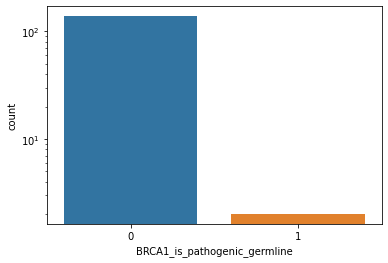

In [174]:
a = combined[combined['disease']=='PDA']
sns.countplot(data=a, x='BRCA1_is_pathogenic_germline')
plt.yscale('log')

In [175]:
drivers = [d for d, gs in gene_to_subgenes.items() if len(gs)>=5]

BR TumorPurity


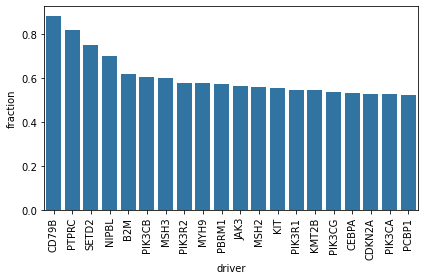

BR driver_gene_cnv


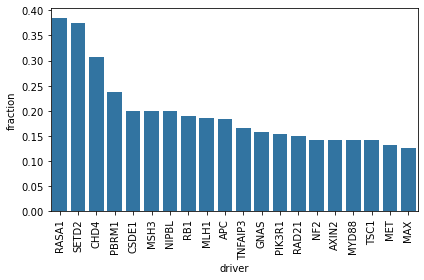

BR driver_gene_is_mutated


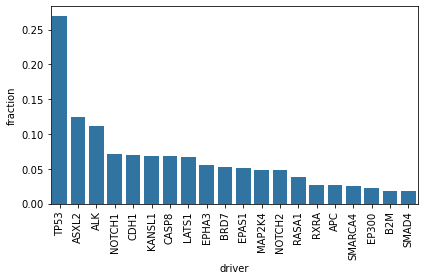

BR driver_gene_is_pathogenic_germline


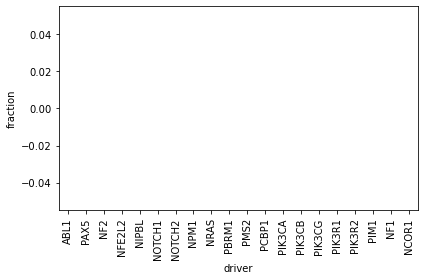

CO TumorPurity


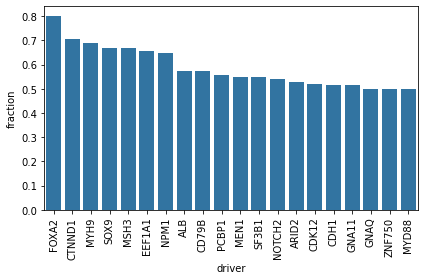

CO driver_gene_cnv


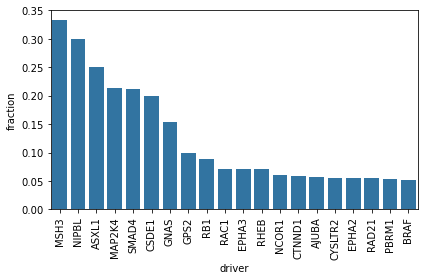

CO driver_gene_is_mutated


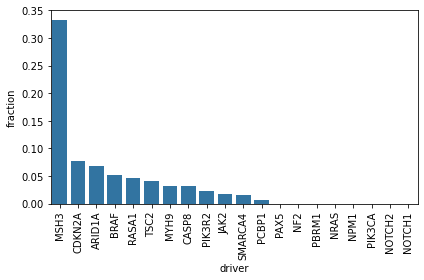

CO driver_gene_is_pathogenic_germline


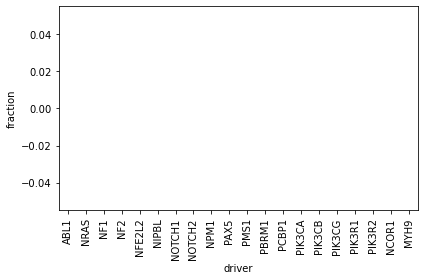

EC TumorPurity


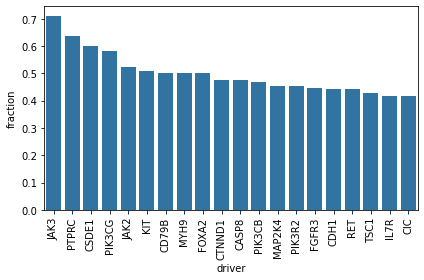

EC driver_gene_cnv


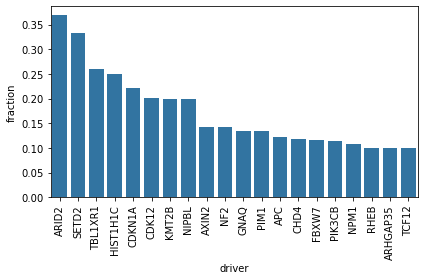

EC driver_gene_is_mutated


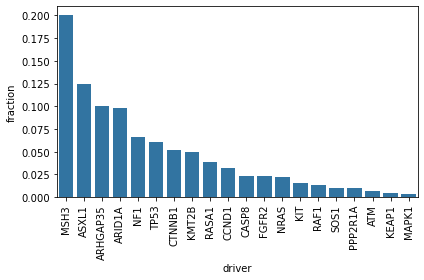

EC driver_gene_is_pathogenic_germline


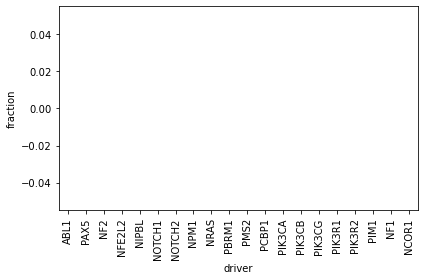

GBM TumorPurity


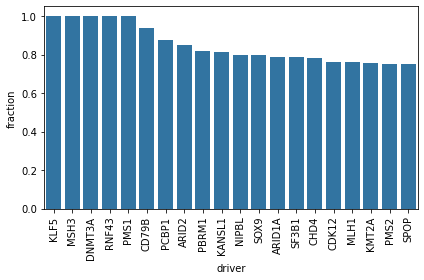

GBM driver_gene_cnv


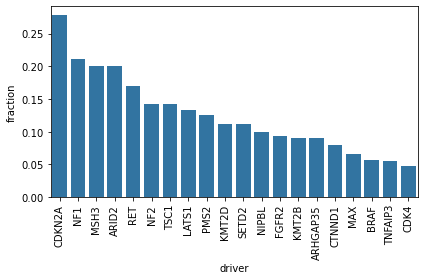

GBM driver_gene_is_mutated


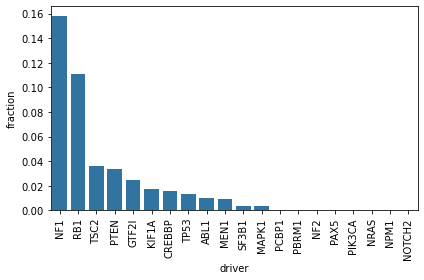

GBM driver_gene_is_pathogenic_germline


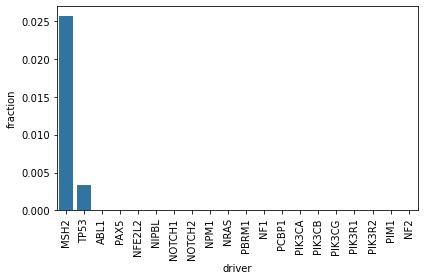

HNSCC TumorPurity


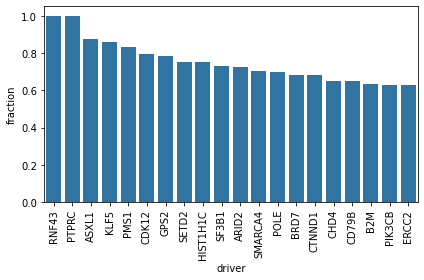

HNSCC driver_gene_cnv


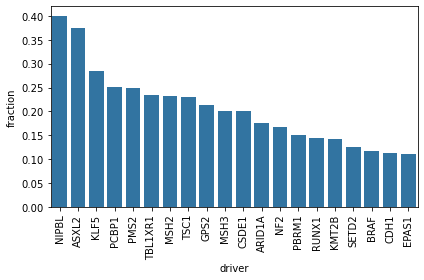

HNSCC driver_gene_is_mutated


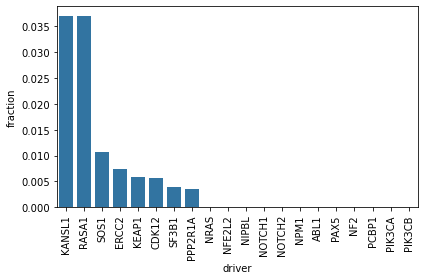

HNSCC driver_gene_is_pathogenic_germline


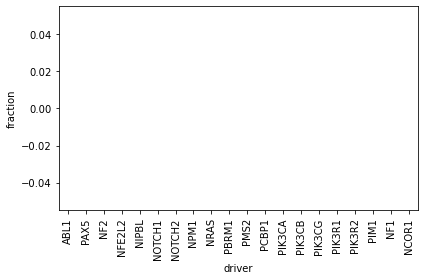

LSCC TumorPurity


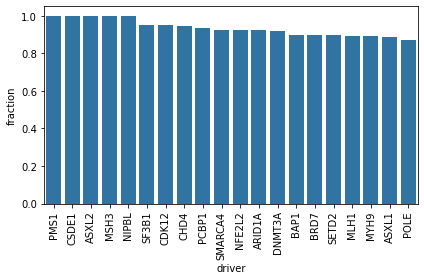

LSCC driver_gene_cnv


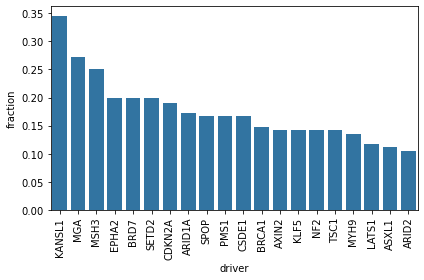

LSCC driver_gene_is_mutated


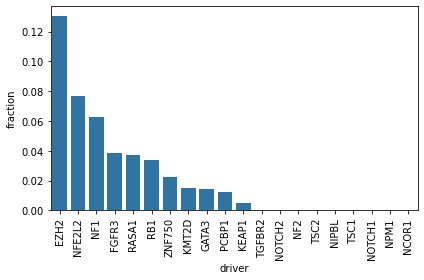

LSCC driver_gene_is_pathogenic_germline


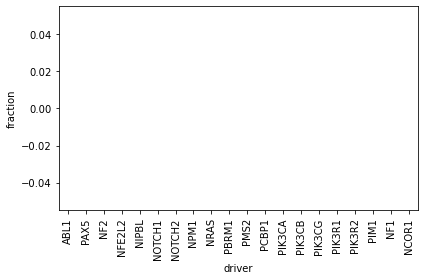

LUAD TumorPurity


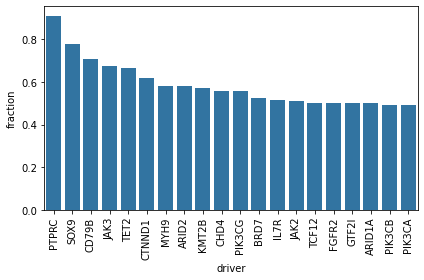

LUAD driver_gene_cnv


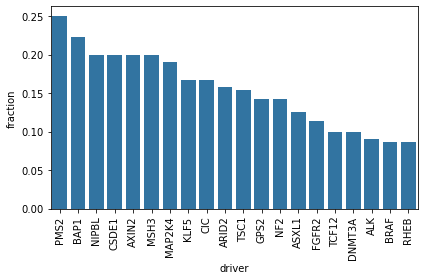

LUAD driver_gene_is_mutated


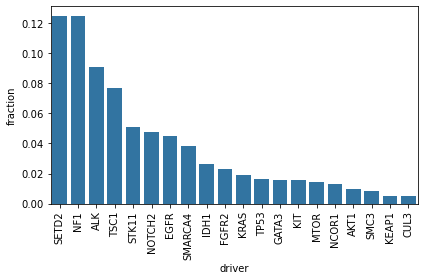

LUAD driver_gene_is_pathogenic_germline


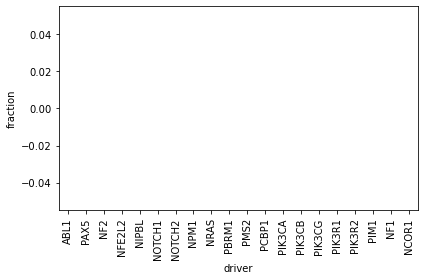

OV TumorPurity


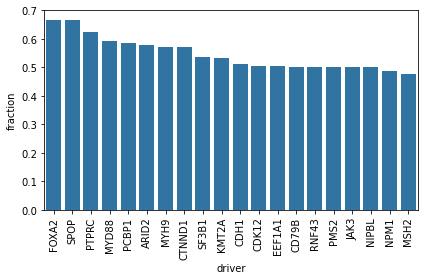

OV driver_gene_cnv


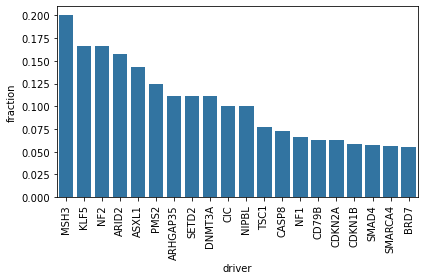

OV driver_gene_is_mutated


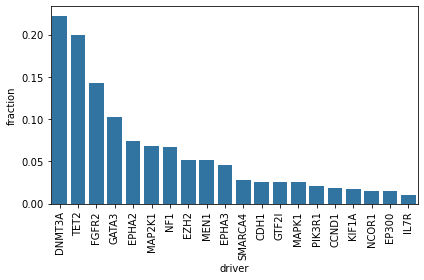

OV driver_gene_is_pathogenic_germline


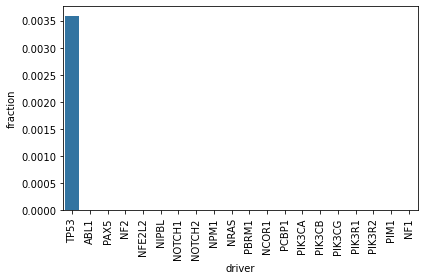

PDA TumorPurity


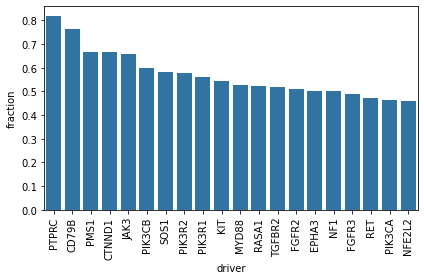

PDA driver_gene_cnv


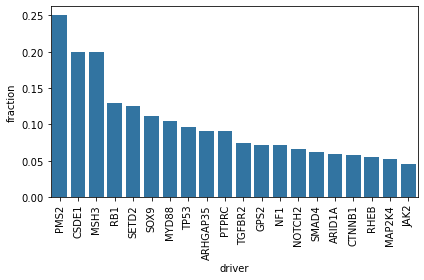

PDA driver_gene_is_mutated


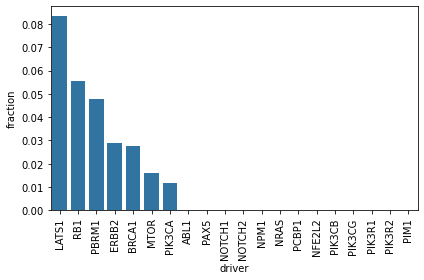

PDA driver_gene_is_pathogenic_germline


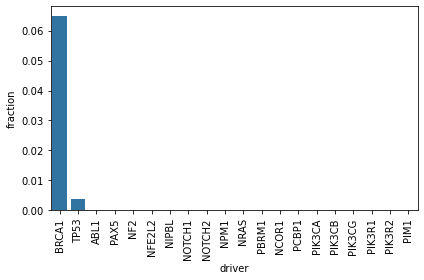

ccRCC TumorPurity


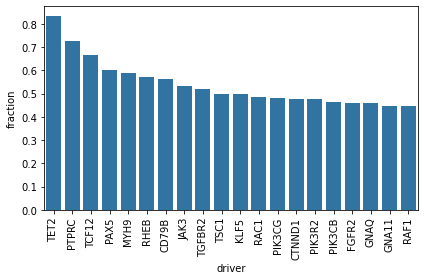

ccRCC driver_gene_cnv


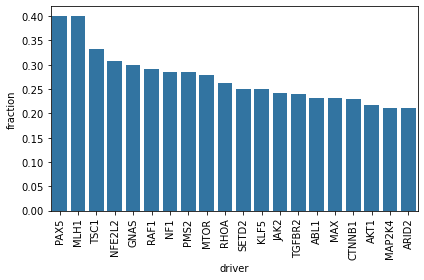

ccRCC driver_gene_is_mutated


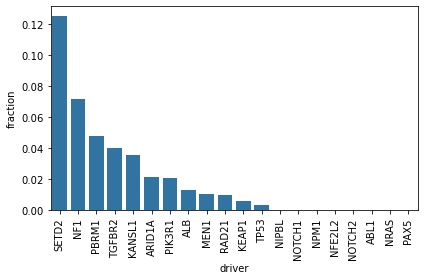

ccRCC driver_gene_is_pathogenic_germline


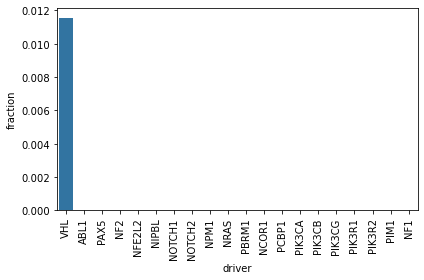

In [176]:
for disease in sorted(set(p['disease'])):
    for feat in sorted(set(p['feature'])):
        source = p[p['feature']==feat]
        source = source[source['disease']==disease]
        source = source[[True if d in drivers else False for d in source['driver']]]
        source = source.sort_values('fraction', ascending=False).iloc[:20]
        print(disease, feat)
        sns.barplot(data=source, x='driver', y='fraction', color=sns.color_palette()[0])
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(figdir, f'coef_fraction_barplot_{disease}_{feat}.pdf'))
        plt.show()
        

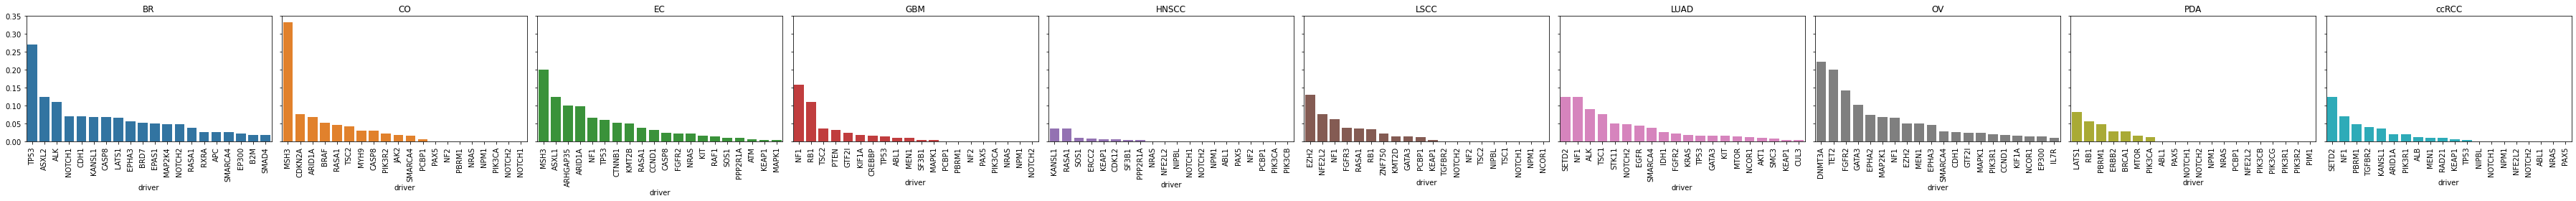

In [177]:
fig, axs = plt.subplots(nrows=1, ncols=len(set(p['disease'])), figsize=(50, 4), sharey=True)
for i, disease in enumerate(sorted(set(p['disease']))):
    ax = axs[i]
    source = p[p['disease']==disease]
    source = source[source['feature']=='driver_gene_is_mutated']
    source = source[[True if d in drivers else False for d in source['driver']]]
    source = source.sort_values('fraction', ascending=False).iloc[:20]
    sns.barplot(data=source, x='driver', y='fraction', color=sns.color_palette()[i], ax=ax)
    ax.set_title(disease)
    ax.set_ylabel('')
    for tick in ax.get_xticklabels(): tick.set_rotation(90)
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'coef_fraction_driver_somatic_mutation.pdf'))

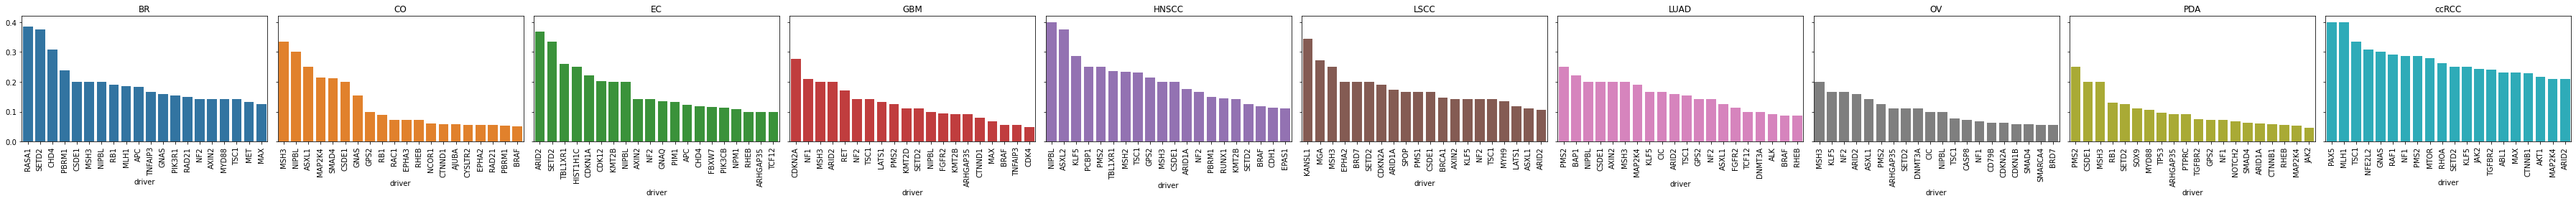

In [218]:
fig, axs = plt.subplots(nrows=1, ncols=len(set(p['disease'])), figsize=(50, 4), sharey=True)
for i, disease in enumerate(sorted(set(p['disease']))):
    ax = axs[i]
    source = p[p['disease']==disease]
    source = source[source['feature']=='driver_gene_cnv']
    source = source[[True if d in drivers else False for d in source['driver']]]
    source = source.sort_values('fraction', ascending=False).iloc[:20]
    sns.barplot(data=source, x='driver', y='fraction', color=sns.color_palette()[i], ax=ax)
    ax.set_title(disease)
    ax.set_ylabel('')
    for tick in ax.get_xticklabels(): tick.set_rotation(90)
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'coef_fraction_driver_gene_cnv.pdf'))

In [67]:
for gene, subgenes in gene_to_subgenes.items():
    print(gene, len(subgenes))

ABL1 126
AJUBA 161
AKT1 244
ALB 108
ALK 13
AMER1 22
APC 53
AR 298
ARAF 43
ARHGAP35 12
ARID1A 52
ARID2 19
ASXL1 10
ASXL2 10
ATM 213
ATRX 1
AXIN1 77
AXIN2 10
B2M 107
BAP1 11
BCL2 49
BCOR 7
BRAF 82
BRCA1 214
BRD7 19
CASP8 51
CCND1 76
CD79B 80
CDH1 66
CDK12 188
CDK4 94
CDKN1A 81
CDKN1B 49
CDKN2A 24
CDKN2C 8
CEBPA 71
CHD4 56
CIC 11
CNBD1 0
CREBBP 216
CSDE1 5
CTCF 212
CTNNB1 172
CTNND1 33
CUL1 365
CUL3 304
CYSLTR2 149
DNMT3A 73
EEF1A1 164
EGFR 310
EGR3 4
EIF1AX 61
EP300 331
EPAS1 48
EPHA2 37
EPHA3 32
ERBB2 126
ERCC2 159
ESR1 428
EZH2 109
FAT1 0
FBXW7 333
FGFR1 118
FGFR2 88
FGFR3 90
FOXA1 107
FOXA2 11
FUBP1 1
GATA3 170
GNA11 179
GNAQ 177
GNAS 120
GPS2 17
GTF2I 40
HGF 104
HIST1H1C 9
HLA-A 71
HLA-B 62
HRAS 72
HUWE1 257
IDH1 46
IDH2 0
IL7R 139
IRF6 0
JAK2 134
JAK3 58
KANSL1 31
KDM5C 0
KDM6A 104
KEAP1 291
KIF1A 82
KIT 107
KLF5 7
KMT2A 130
KMT2B 84
KMT2C 116
KMT2D 137
KRAS 59
LATS1 18
LATS2 22
MACF1 1
MAP2K1 90
MAP2K4 24
MAP3K1 22
MAPK1 335
MAX 20
MED12 54
MEN1 135
MET 132
MGA 12
MGMT 2
MLH1 35
MS

###### coef and model correlation paired plots

In [95]:
import matplotlib.pyplot as plt
def plot_scatter_feature(results, figsize=(20, 4)):
    diseases = sorted(results.keys())
    fig, axs = plt.subplots(ncols=len(diseases), nrows=2, figsize=figsize)
    for i, disease in enumerate(diseases):
        r = results[disease]
        p_value, x, y, coef_df = round(r['r-squared FDR'], 5), r['groundtruth'], r['predicted'], r['coef_df']
        
        ax1 = axs[0, i]
        ax2 = axs[1, i]
        
        d = pd.DataFrame.from_dict({'groundtruth': x, 'predicted': y})
        sns.regplot(data=d, x='groundtruth', y='predicted', ax=ax1)
        
    
        ax1.set_title(f'{disease}, p-value: {p_value}')
        
        d = pd.DataFrame({'coef': coef_df.iloc[1:]['coef'], 'feature': coef_df.iloc[1:].index})
        sns.barplot(data=d, x='feature', y='coef', ax=ax2)
        plt.xticks(rotation=90)
        

        for ax in [ax1, ax2]:
            ax.set_ylabel('')
            ax.set_xlabel('') 
        if len(diseases) - i != 1:
            ax2.set_xticks([])
        
    plt.subplots_adjust(hspace=.2, wspace=.2)
    plt.tight_layout()

In [110]:
r['BR']['PIK3CA_AKT1'].keys()

dict_keys(['coef_df', 'groundtruth', 'predicted', 'features', 'X', 'y'])

In [83]:
results_dict['BR']['TP53_TP53']['coef_df']

,coef,p-value,FDR,-log10(FDR)
Intercept,22.440456,1.099899e-148,1.108201e-148,147.955381
driver_gene_cnv,0.188514,2.960329e-02,2.293797e-01,0.639445
TumorPurity,-0.112565,1.887817e-01,3.146317e-01,0.502198
driver_gene_is_mutated,0.740215,2.518382e-05,3.530772e-03,2.452130
driver_gene_is_pathogenic_germline,0.000000,NaN,1.000000e+00,0.000000


In [113]:
results = {k:v2 for k, v in r.items() for k2, v2 in v.items()
          if k2=='TP53_TP53'}

In [114]:
for disease, result in results.items():
    coef_df = result['coef_df']
    for feat in coef_df.iloc[1:].index:
        if coef_df.loc[feat, 'FDR'] < .05: print(disease, feat, coef_df.loc[feat, 'FDR'])

BR driver_gene_expression 7.094104695459951e-09
BR driver_gene_is_mutated 2.044736020423679e-07
CO driver_gene_cnv 0.02502216237779127
EC driver_gene_cnv 0.00015828673489010832
EC driver_gene_is_mutated 1.2755863554248648e-05
GBM driver_gene_expression 0.0010766190691613288
GBM driver_gene_is_mutated 1.5022438482416724e-07
GBM driver_gene_is_pathogenic_germline 0.029787655494064685
HNSCC driver_gene_expression 1.124904045014916e-11
HNSCC driver_gene_is_mutated 0.035324092123539666
LSCC driver_gene_expression 9.747776095056649e-17
LSCC driver_gene_is_mutated 0.016081728749310898
LUAD driver_gene_expression 0.00014838967457096825
LUAD driver_gene_is_mutated 5.930776451815072e-08
OV driver_gene_cnv 0.035825816970225466
OV driver_gene_expression 6.609054208342391e-10
OV driver_gene_frameshift_mutation 0.03519975865683985
OV driver_gene_is_mutated 0.02566336718694527
PDA driver_gene_cnv 0.003626133853689116
PDA driver_gene_expression 0.0007182441089739431


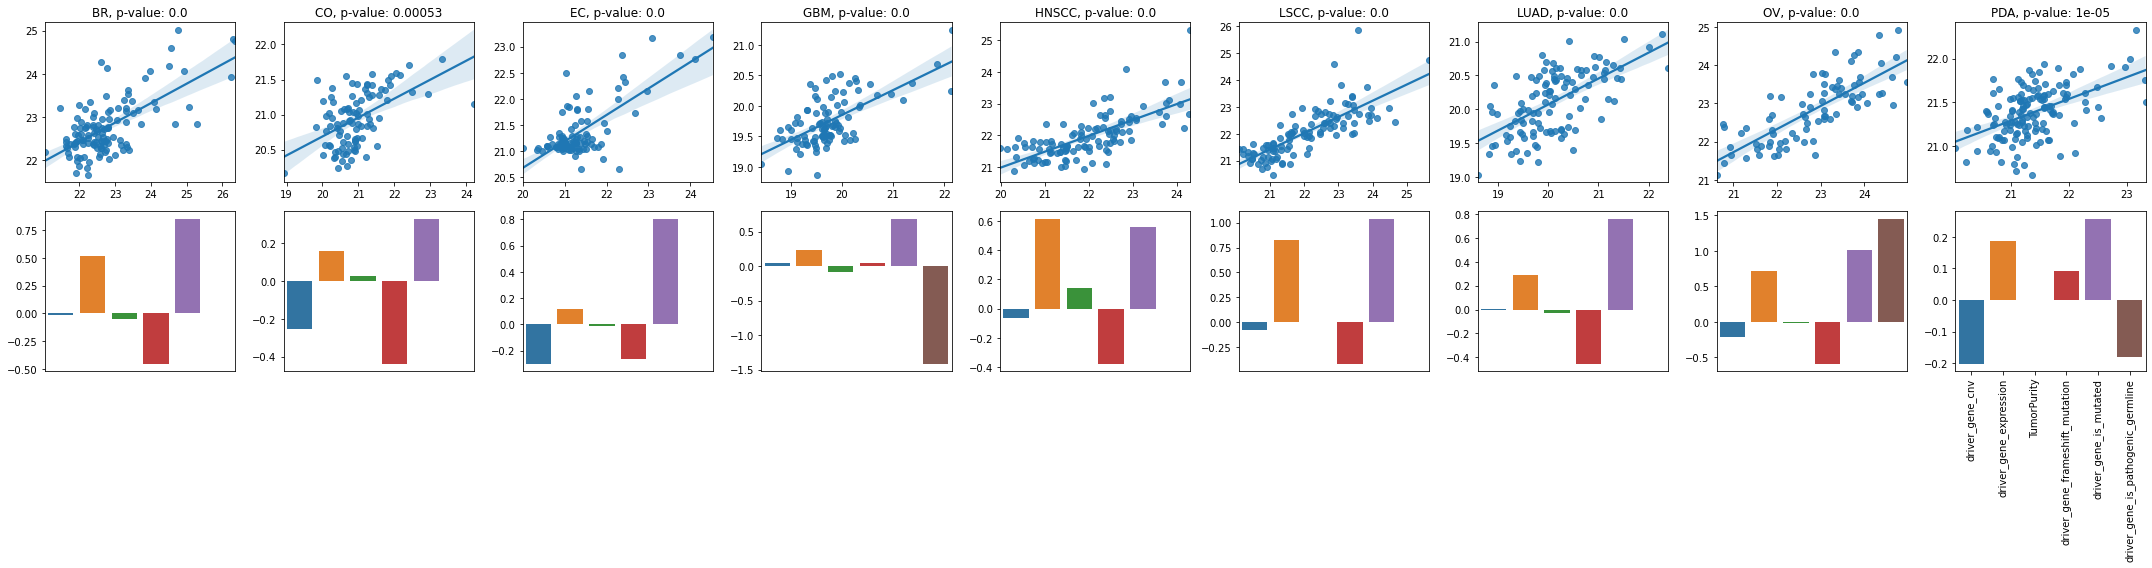

In [116]:
import seaborn as sns
plot_scatter_feature(results, figsize=(30, 8))
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'correlation_plus_coefficient_plot_TP53_TP53.pdf'))

In [181]:
results = {k:v2 for k, v in results_dict.items() for k2, v2 in v.items()
          if k2=='TP53_EGFR'}
for disease, result in results.items():
    coef_df = result['coef_df']
    for feat in coef_df.iloc[1:].index:
        if coef_df.loc[feat, 'FDR'] < .05: print(disease, feat, coef_df.loc[feat, 'FDR'])

BR driver_gene_is_mutated 0.0016111477706785462
GBM TumorPurity 2.259426870662121e-05
HNSCC TumorPurity 0.015027811671396328
LUAD driver_gene_cnv 0.009264445792303105
ccRCC TumorPurity 0.008882510154465466


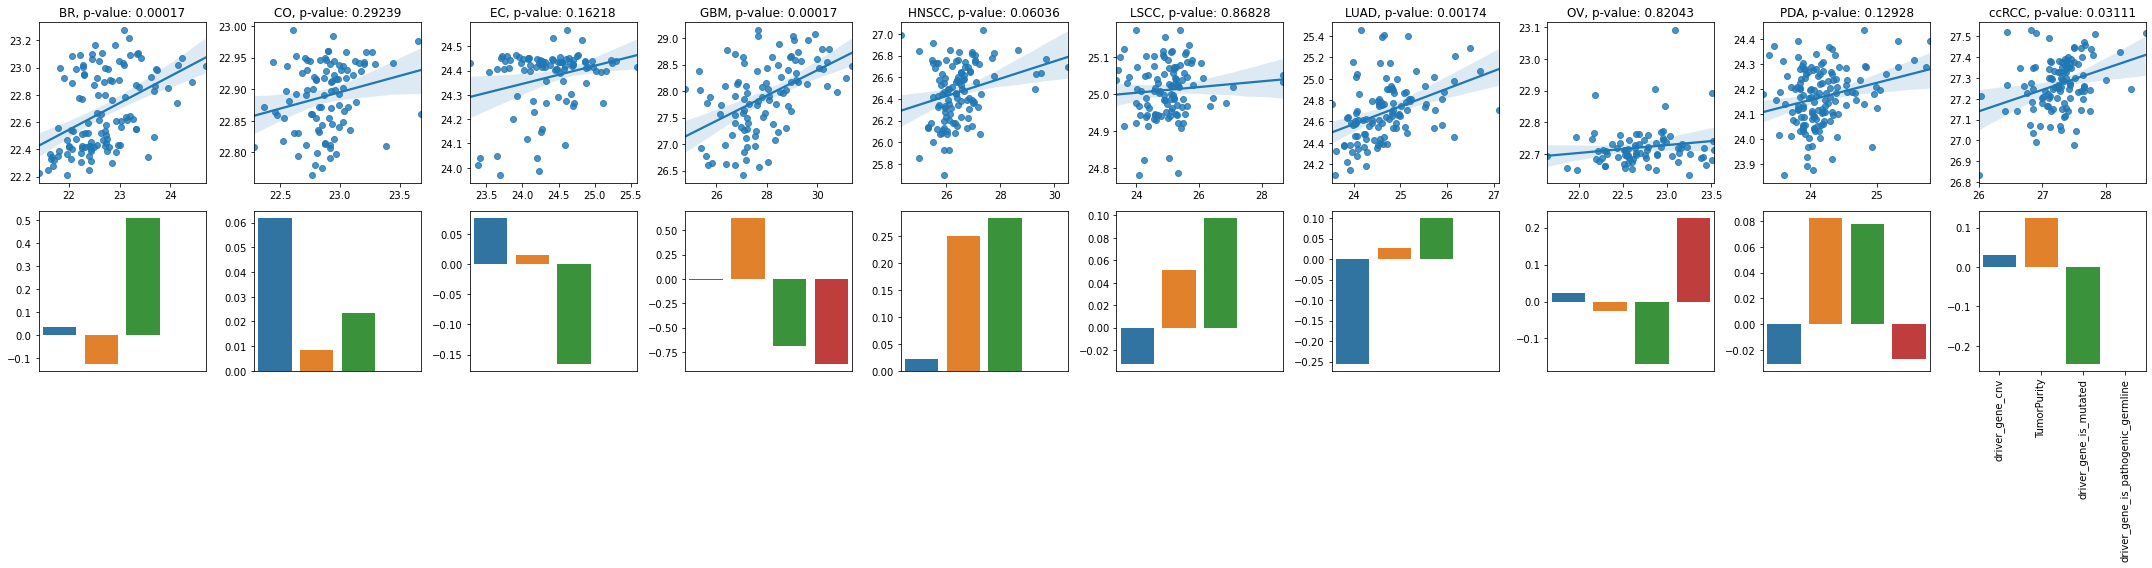

In [182]:
plot_scatter_feature(results, figsize=(30, 8))
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'correlation_plus_coefficient_plot_TP53_EGFR.pdf'))

BR driver_gene_cnv 2.7611267395833457e-07
EC driver_gene_cnv 0.0005168307665218262
EC TumorPurity 0.008235458650242089
GBM driver_gene_cnv 5.9004724083884736e-05
HNSCC driver_gene_cnv 3.6154611623855106e-17
HNSCC TumorPurity 0.02383568045498985
LSCC driver_gene_cnv 4.283668147315644e-18
LSCC TumorPurity 0.013719486475984774
LUAD driver_gene_cnv 0.017720004586830578
LUAD TumorPurity 0.002916705777261428
ccRCC driver_gene_cnv 2.4422298958771194e-06


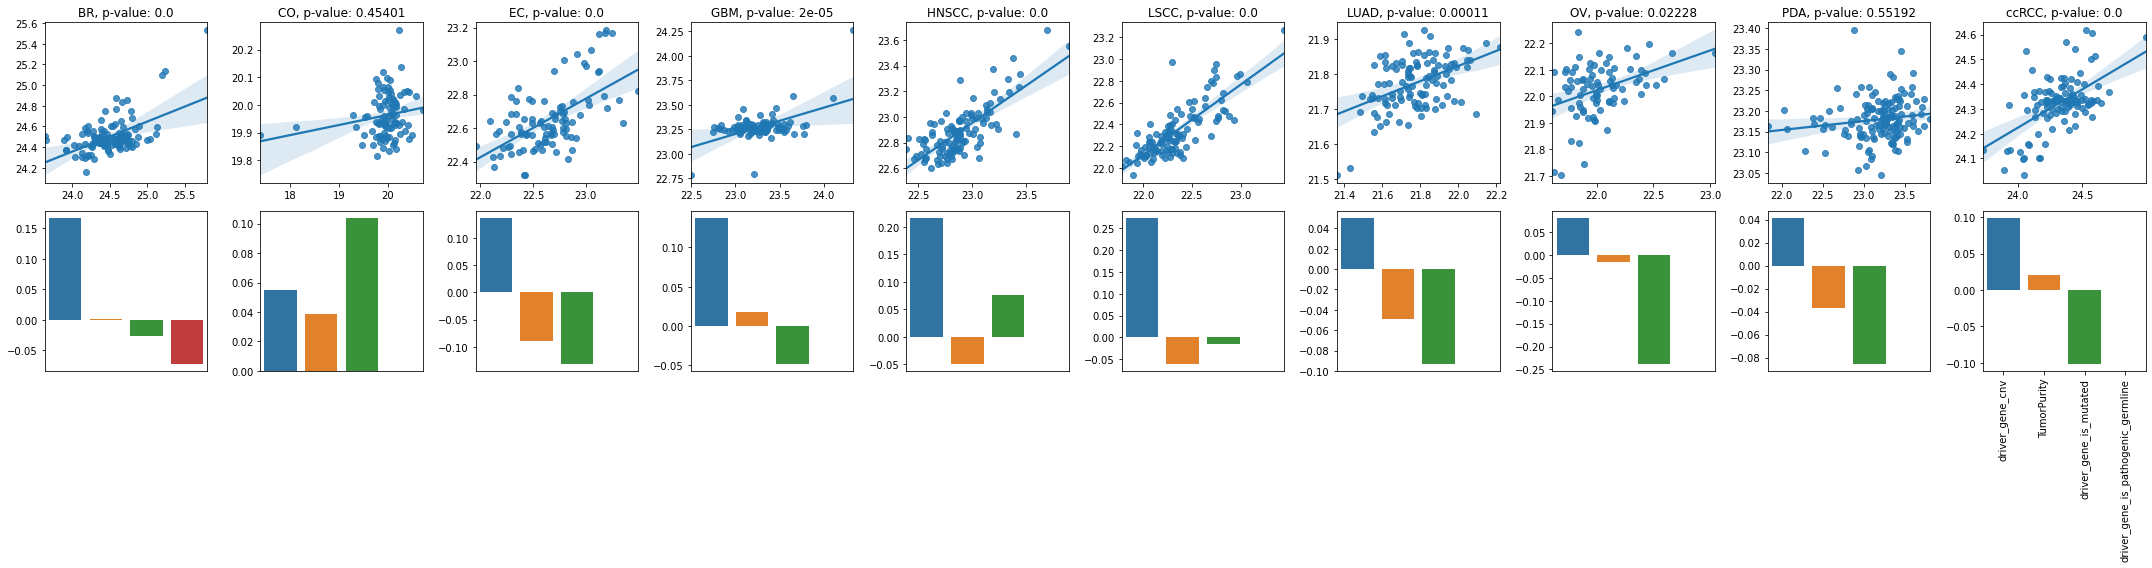

In [219]:
results = {k:v2 for k, v in results_dict.items() for k2, v2 in v.items()
          if k2=='PIK3CA_PIK3CA'}
for disease, result in results.items():
    coef_df = result['coef_df']
    for feat in coef_df.iloc[1:].index:
        if coef_df.loc[feat, 'FDR'] < .05: print(disease, feat, coef_df.loc[feat, 'FDR'])
            
plot_scatter_feature(results, figsize=(30, 8))
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'correlation_plus_coefficient_plot_PIK3CA_PIK3CA.pdf'))

BR TumorPurity 0.036541709224863834
CO TumorPurity 0.007945485279435161
EC TumorPurity 0.007403370932753053
GBM TumorPurity 0.017943107011494663
HNSCC TumorPurity 1.0520559289625297e-09
LSCC TumorPurity 3.885434739079902e-12
LUAD TumorPurity 3.139968676947407e-10
OV TumorPurity 2.2279025023495833e-05
PDA TumorPurity 1.4395887387123595e-07
ccRCC TumorPurity 0.0007574309351838332


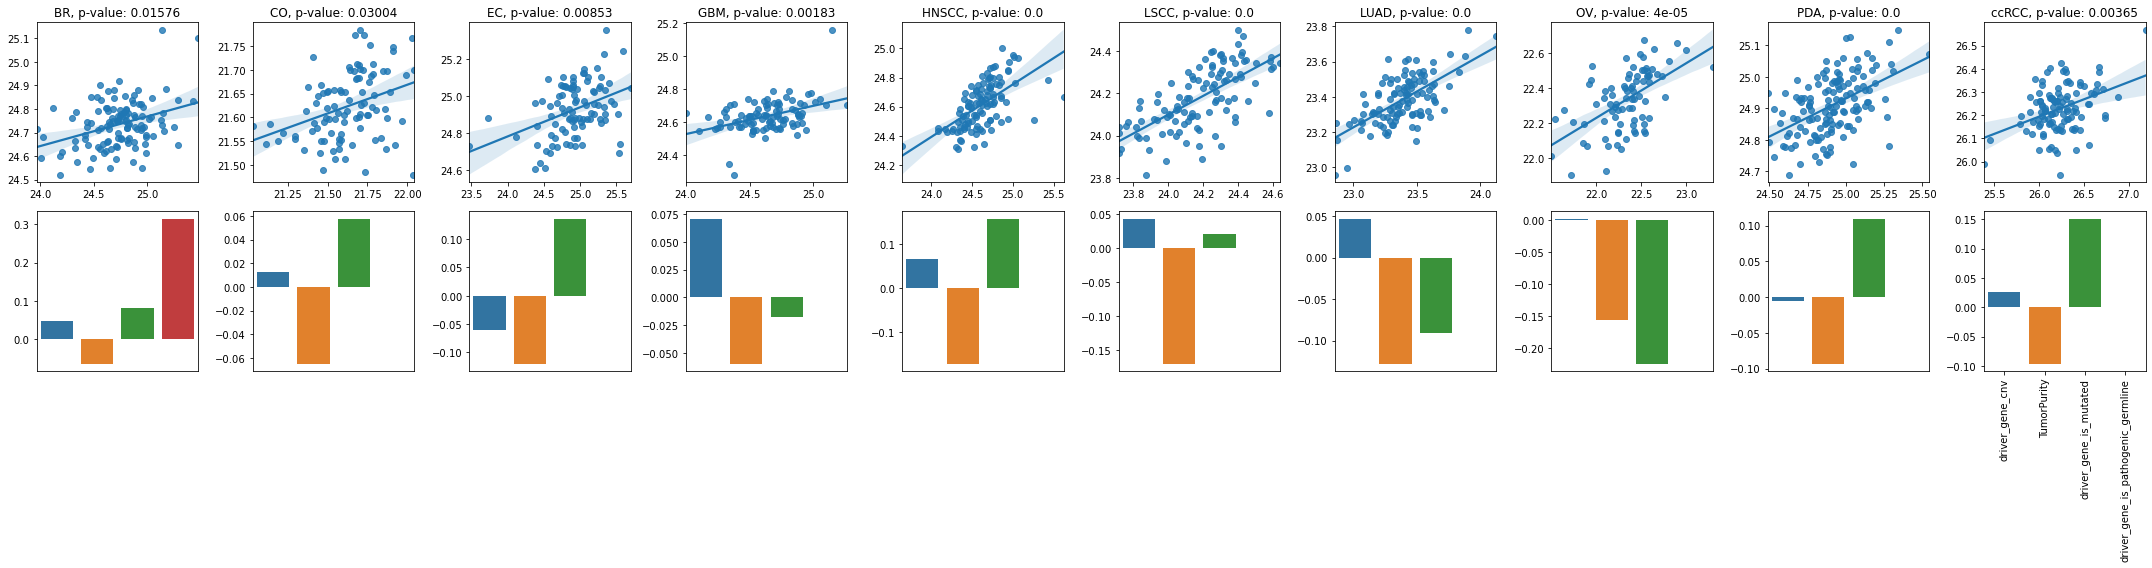

In [220]:
results = {k:v2 for k, v in results_dict.items() for k2, v2 in v.items()
          if k2=='PIK3CA_PIK3R1'}
for disease, result in results.items():
    coef_df = result['coef_df']
    for feat in coef_df.iloc[1:].index:
        if coef_df.loc[feat, 'FDR'] < .05: print(disease, feat, coef_df.loc[feat, 'FDR'])
            
plot_scatter_feature(results, figsize=(30, 8))
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'correlation_plus_coefficient_plot_PIK3CA_PIK3R1.pdf'))

In [204]:
{'_'.join(x.split('_')[1:]) for x in combined.columns}

{'',
 'cnv',
 'is_mutated',
 'is_pathogenic_germline',
 'mutation_is_Frame_Shift_Del',
 'mutation_is_Frame_Shift_Ins',
 'mutation_is_In_Frame_Del',
 'mutation_is_In_Frame_Ins',
 'mutation_is_Missense_Mutation',
 'mutation_is_Nonsense_Mutation',
 'mutation_is_Nonstop_Mutation',
 'mutation_is_Splice_Site',
 'proteome'}

In [206]:
x = combined[['TP53_cnv', 'TP53_is_mutated', 'TP53_is_pathogenic_germline', 'ESR1_proteome', 'TumorPurity']].copy()
x.columns = ['TP53 CNV', 'TP53 somatic mutation status', 'TP53 germline mutation status', 'ESR1 proteome', 'tumor purity']
x['TP53 somatic mutation status'] = ['mutated' if m else 'wildtype' for m in x['TP53 somatic mutation status']]
x

,TP53 CNV,TP53 somatic mutation status,TP53 germline mutation status,ESR1 proteome,tumor purity
sample_id,,,,,
01BR001-T,0.22080,mutated,0,22.988479,0.816624
01BR008-T,-0.02004,mutated,0,22.546756,0.510466
01BR009-T,0.34555,wildtype,0,23.140870,0.556239
01BR010-T,-0.14187,wildtype,0,22.913404,0.747700
01BR015-T,-0.18660,mutated,0,22.698077,0.649161
...,...,...,...,...,...
C3N-04119-T,-0.14516,mutated,0,NaN,0.530830
C3N-04126-T,-0.19759,mutated,0,NaN,0.464536
C3N-04282-T,-0.29080,wildtype,0,NaN,0.604708


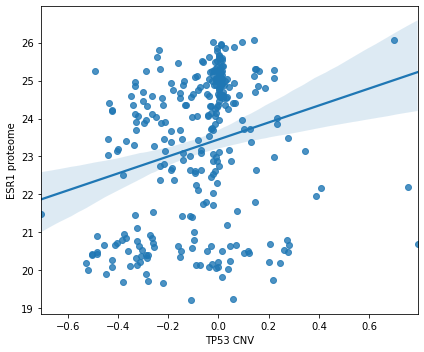

In [213]:
plt.subplots(figsize=(6, 5))
sns.regplot(data=x, x='TP53 CNV', y='ESR1 proteome')
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'correlation_plot_cnv_TP53_EGFR.pdf'))

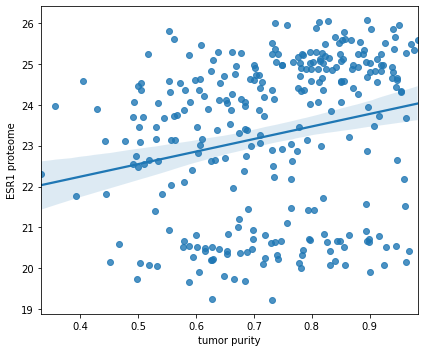

In [214]:
plt.subplots(figsize=(6, 5))
sns.regplot(data=x, x='tumor purity', y='ESR1 proteome')
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'correlation_plot_tumor_purity_TP53_EGFR.pdf'))

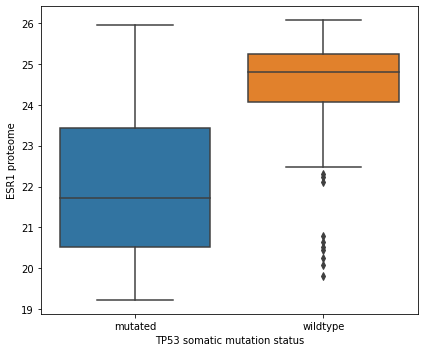

In [215]:
plt.subplots(figsize=(6, 5))
sns.boxplot(data=x, x='TP53 somatic mutation status', y='ESR1 proteome')
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'correlation_plot_somatic_status_TP53_EGFR.pdf'))

In [93]:
gene_to_subgenes['TP53']

['ABCB1',
 'ACTA2',
 'ADA',
 'AEN',
 'AFP',
 'AIFM2',
 'AKT1',
 'ALOX5',
 'ANTXR1',
 'ANXA4',
 'AP3M1',
 'APAF1',
 'APCS',
 'ARFGEF2',
 'ARID3A',
 'ASCC3',
 'ATF2',
 'ATF3',
 'ATM',
 'ATR',
 'AURKA',
 'AURKB',
 'AXIN1',
 'BAI1',
 'BAK1',
 'BANP',
 'BARD1',
 'BAX',
 'BBC3',
 'BCL2',
 'BCL2L1',
 'BCL2L14',
 'BCL3',
 'BCL6',
 'BDKRB2',
 'BID',
 'BIRC5',
 'BLM',
 'BNIP3L',
 'BRCA1',
 'BRCA2',
 'BRD1',
 'BRD7',
 'BRPF1',
 'BRPF3',
 'BTG2',
 'BTG3',
 'CABLES1',
 'CARM1',
 'CASP1',
 'CASP10',
 'CASP3',
 'CASP6',
 'CAV1',
 'CCDC8',
 'CCNA1',
 'CCNA2',
 'CCNB1',
 'CCND1',
 'CCNE1',
 'CCNE2',
 'CCNG1',
 'CCNK',
 'CCT2',
 'CCT3',
 'CCT4',
 'CCT5',
 'CCT6A',
 'CCT6B',
 'CCT7',
 'CCT8',
 'CD82',
 'CDC14A',
 'CDC14B',
 'CDC25C',
 'CDK1',
 'CDK2',
 'CDK5',
 'CDK5R1',
 'CDK7',
 'CDK9',
 'CDKN1A',
 'CDKN1B',
 'CDKN2A',
 'CHEK1',
 'CHEK2',
 'CHMP4C',
 'CHUK',
 'CKM',
 'COL18A1',
 'COP1',
 'COPS2',
 'COPS3',
 'COPS4',
 'COPS5',
 'COPS6',
 'COPS7A',
 'COPS8',
 'CREBBP',
 'CSNK1A1',
 'CSNK1D',
 'CSNK2A1',


In [124]:
len(gene_to_subgenes['PIK3CA'])

256

In [98]:
results = {k:v2 for k, v in results_dict.items() for k2, v2 in v.items()
          if k2=='TP53_EGFR'}
for disease, result in results.items():
    coef_df = result['coef_df']
    for feat in coef_df.iloc[1:].index:
        if coef_df.loc[feat, 'FDR'] < .05: print(disease, feat, coef_df.loc[feat, 'FDR'])

BR driver_gene_is_mutated 0.0016111477706785462
GBM TumorPurity 2.259426870662121e-05
HNSCC TumorPurity 0.015027811671396328
LUAD driver_gene_cnv 0.009264445792303105
ccRCC TumorPurity 0.008882510154465466


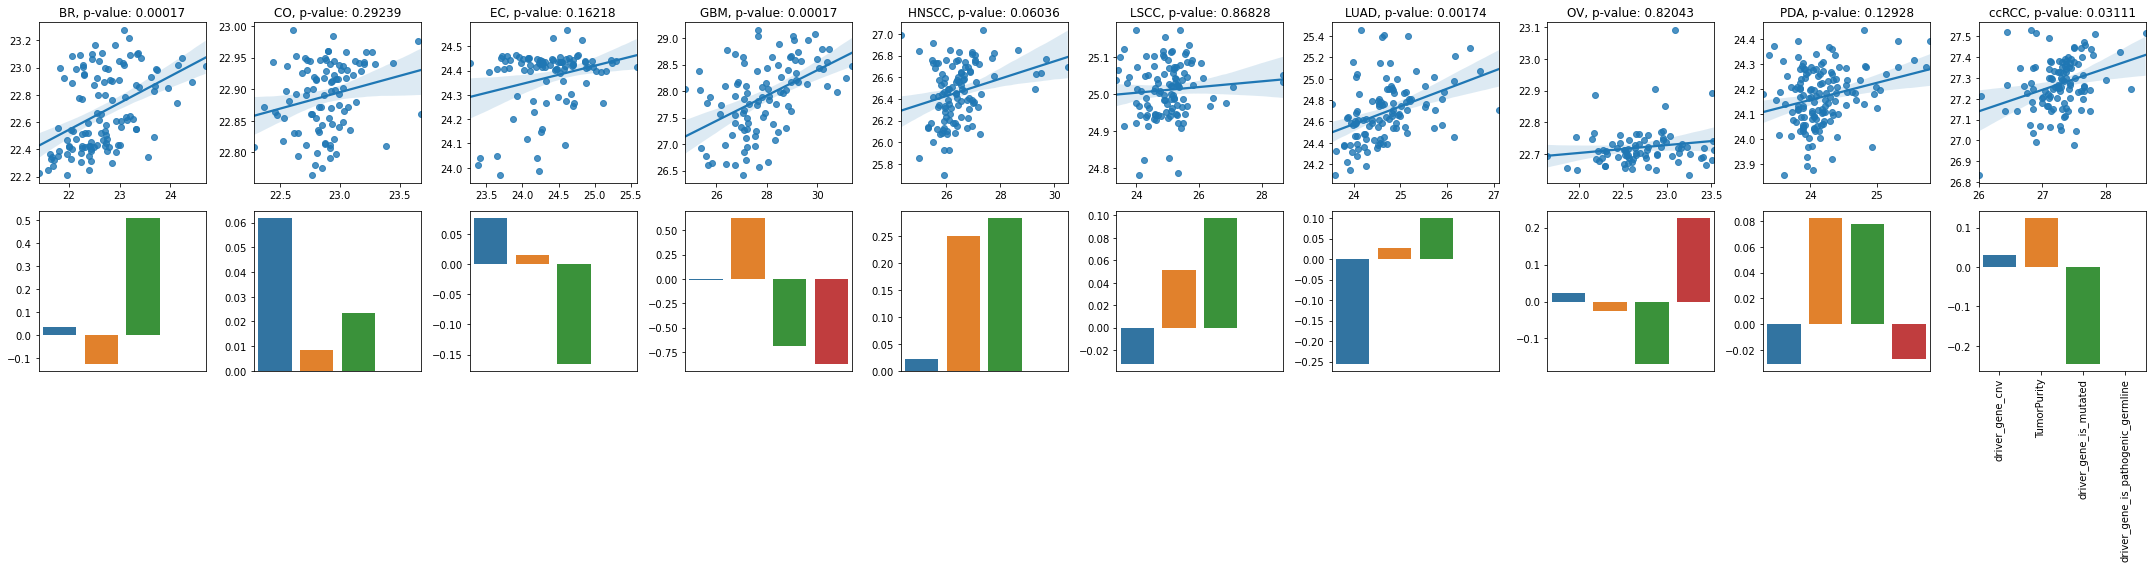

In [96]:
plot_scatter_feature(results, figsize=(30, 8))

###### volcano plots

In [ ]:
# lets make a volcano plot

In [51]:
import seaborn as sns

In [52]:
master_coef_df = None
for disease, results in results_dict.items():
    for k, r in results.items():
        driver, subgene = k.split('_')
        df = r['coef_df'].copy()
        # drop the intercept
        df = df.iloc[1:, :]
        df['feature'] = df.index.to_list()
        df.index = np.arange(df.shape[0])
        
        # replace 1. fdr with np.nan
        df['FDR'] = [np.nan if pd.isnull(p) else x for p, x in zip(df['p-value'], df['FDR'])]
        df['-log10(FDR)'] = [np.nan if pd.isnull(p) else x for p, x in zip(df['p-value'], df['-log10(FDR)'])]
        
        df['driver'] = driver
        df['target'] = subgene
        df['disease'] = disease
        df['model_r2'] = r['r-squared']
        df['model_r2_FDR'] = r['r-squared FDR']
        
        if master_coef_df is None:
            master_coef_df = df.copy()
        else:
            master_coef_df = pd.concat((master_coef_df, df))
master_coef_df.index = np.arange(master_coef_df.shape[0])

In [53]:
master_coef_df

,coef,p-value,FDR,-log10(FDR),feature,driver,target,disease,model_r2,model_r2_FDR
0,-0.034324,7.216432e-02,3.615290e-01,0.441857,driver_gene_cnv,ABL1,ABI1,BR,0.005537,4.310828e-01
1,-0.009837,6.046619e-01,7.309830e-01,0.136093,TumorPurity,ABL1,ABI1,BR,0.005537,4.310828e-01
2,0.069500,6.370391e-01,9.757770e-01,0.010649,driver_gene_is_mutated,ABL1,ABI1,BR,0.005537,4.310828e-01
3,0.000000,NaN,NaN,NaN,driver_gene_is_pathogenic_germline,ABL1,ABI1,BR,0.005537,4.310828e-01
4,0.179461,7.645052e-11,5.102308e-08,7.292233,driver_gene_cnv,ABL1,ABL1,BR,0.292508,9.747623e-08
...,...,...,...,...,...,...,...,...,...,...
378847,0.000000,NaN,NaN,NaN,driver_gene_is_pathogenic_germline,ZNF750,ZNF706,ccRCC,0.009613,3.984553e-01
378848,0.067997,1.683222e-01,3.237714e-01,0.489761,TumorPurity,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01
378849,-0.003108,9.495019e-01,9.797429e-01,0.008888,driver_gene_cnv,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01
378850,0.828135,1.080325e-01,9.530489e-01,0.020885,driver_gene_is_mutated,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01


In [194]:
# lets rename feature names so its nicer
rename = {
    'driver_gene_cnv': 'driver CNV',
    'TumorPurity': 'tumor purity',
    'driver_gene_is_mutated': 'driver somatic mutation',
    'driver_gene_is_pathogenic_germline': 'driver germline mutation'
}
p = master_coef_df.copy()
p['feature'] = [rename[x] for x in p['feature']]

In [196]:
def plot_feat_coef_by_disease(gene, master_coef_df, figsize=(25, 4)):
    fig, axs = plt.subplots(ncols=len(set(master_coef_df['disease'])), nrows=1, figsize=figsize, sharey=True,
                           sharex=False)
    for i, disease in enumerate(sorted(set(master_coef_df['disease']))):
        ax = axs[i]
        filtered = master_coef_df[master_coef_df['disease']==disease]
        filtered = filtered[filtered['driver']==gene]

        sns.scatterplot(data=filtered, x='coef', y='-log10(FDR)', hue='feature',
                        legend=None if i!=len(set(master_coef_df['disease']))-1 else True,
                        ax=ax)
        ax.axhline(y=-np.log10(.05), linestyle='dotted', color='gray')
        ax.axvline(x=0., linestyle='dotted', color='gray')

        if i == len(set(master_coef_df['disease']))-1:
            plt.legend(bbox_to_anchor=(1.1, 1.0))
        ax.set_title(disease)
#     plt.show()

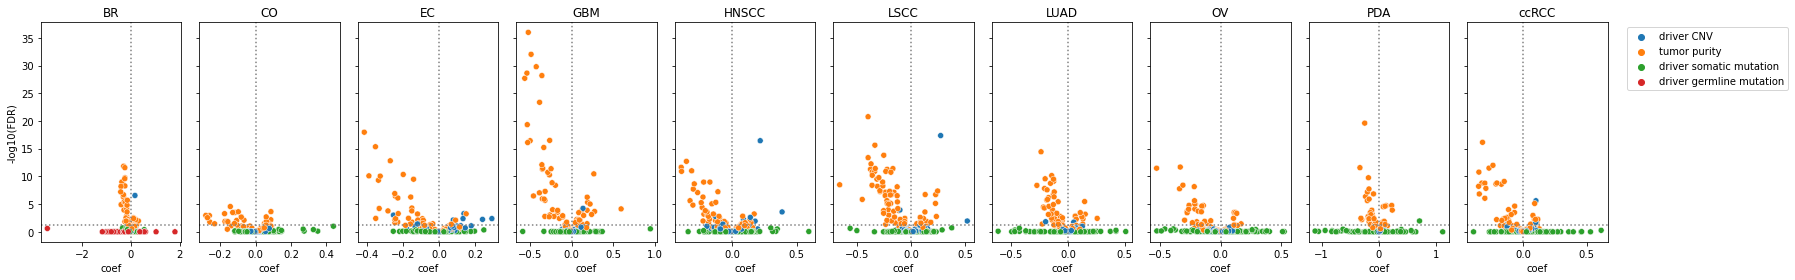

In [197]:
# do by disease
plot_feat_coef_by_disease('PIK3CA', p)
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'volcano_coefficient_plot_PIK3CA.pdf'))

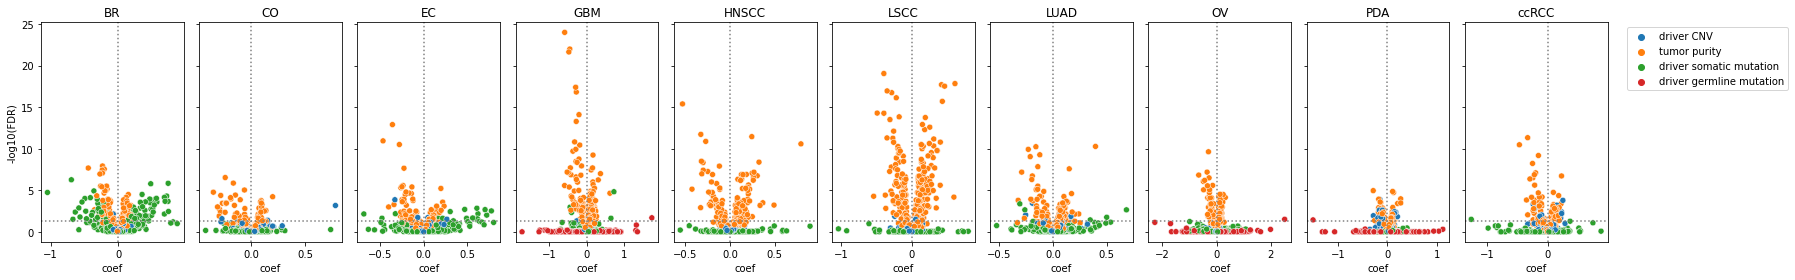

In [198]:
# do by disease
plot_feat_coef_by_disease('TP53', p)
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'volcano_coefficient_plot_TP53.pdf'))

In [146]:
p

,coef,p-value,FDR,-log10(FDR),feature,driver,target,disease,model_r2,model_r2_FDR
0,-0.034324,7.216432e-02,3.615290e-01,0.441857,driver CNV,ABL1,ABI1,BR,0.005537,4.310828e-01
1,-0.009837,6.046619e-01,7.309830e-01,0.136093,tumor purity,ABL1,ABI1,BR,0.005537,4.310828e-01
2,0.069500,6.370391e-01,9.757770e-01,0.010649,driver somatic mutation,ABL1,ABI1,BR,0.005537,4.310828e-01
3,0.000000,NaN,NaN,NaN,driver germline mutation,ABL1,ABI1,BR,0.005537,4.310828e-01
4,0.179461,7.645052e-11,5.102308e-08,7.292233,driver CNV,ABL1,ABL1,BR,0.292508,9.747623e-08
...,...,...,...,...,...,...,...,...,...,...
378847,0.000000,NaN,NaN,NaN,driver germline mutation,ZNF750,ZNF706,ccRCC,0.009613,3.984553e-01
378848,0.067997,1.683222e-01,3.237714e-01,0.489761,tumor purity,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01
378849,-0.003108,9.495019e-01,9.797429e-01,0.008888,driver CNV,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01
378850,0.828135,1.080325e-01,9.530489e-01,0.020885,driver somatic mutation,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01


In [148]:
a = p[p['driver']=='TP53']
a[a['feature']=='driver somatic mutation'].sort_values('FDR', ascending=True).iloc[:10]

,coef,p-value,FDR,-log10(FDR),feature,driver,target,disease,model_r2,model_r2_FDR
38170,-0.695344,2.342364e-10,5.473324e-07,6.261749,driver somatic mutation,TP53,FUCA1,BR,0.282895,1.938918e-07
38234,0.735706,8.281246e-10,1.451288e-06,5.838246,driver somatic mutation,TP53,ICAM1,BR,0.343370,2.943304e-09
38098,0.478199,1.175629e-09,1.648231e-06,5.782982,driver somatic mutation,TP53,ETS1,BR,0.444185,1.204083e-12
38030,-0.362071,1.028082e-08,1.201143e-05,4.920405,driver somatic mutation,TP53,DDB2,BR,0.252022,1.657644e-06
147750,0.733436,1.252032e-08,1.495761e-05,4.825138,driver somatic mutation,TP53,TP53,GBM,0.282930,3.307787e-06
38094,-1.049126,1.818555e-08,1.821153e-05,4.739654,driver somatic mutation,TP53,ESR1,BR,0.289287,1.213144e-07
38046,0.350136,4.073500e-08,3.172804e-05,4.498557,driver somatic mutation,TP53,DUSP11,BR,0.212546,1.974211e-05
37778,0.713646,7.018998e-08,4.920318e-05,4.308007,driver somatic mutation,TP53,BIRC5,BR,0.204546,3.208747e-05
37898,0.680171,1.109266e-07,7.069050e-05,4.150639,driver somatic mutation,TP53,CDK1,BR,0.222288,1.086495e-05
37810,-0.414676,1.337388e-07,7.812576e-05,4.107206,driver somatic mutation,TP53,CABLES1,BR,0.292557,9.746714e-08


TumorPurity


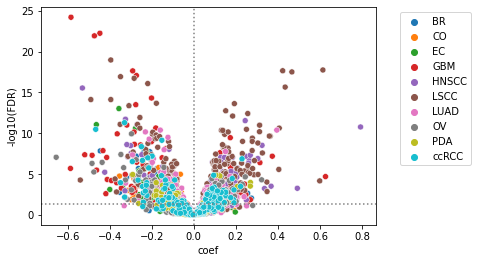

driver_gene_cnv


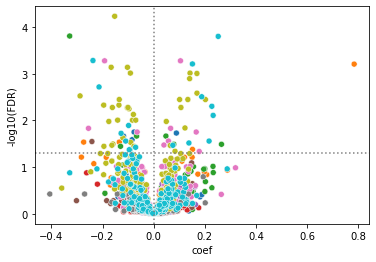

driver_gene_is_mutated


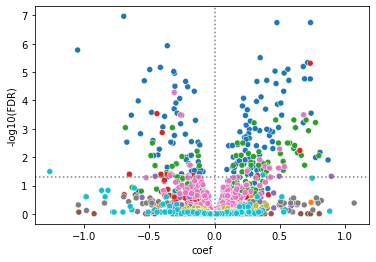

driver_gene_is_pathogenic_germline


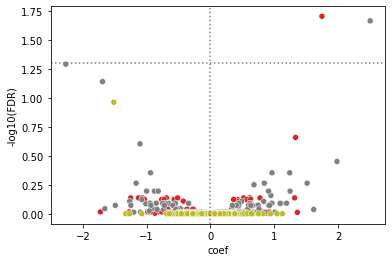

In [379]:
# do by disease
import matplotlib.pyplot as plt
for i, feat in enumerate(sorted(set(master_coef_df['feature']))):
    filtered = master_coef_df[master_coef_df['feature']==feat]
    filtered = filtered[filtered['driver']=='TP53']
    print(feat)
    
    sns.scatterplot(data=filtered, x='coef', y='-log10(FDR)', hue='disease', legend=None if i!=0 else True)
    plt.axhline(y=-np.log10(.05), linestyle='dotted', color='gray')
    plt.axvline(x=0., linestyle='dotted', color='gray')
    if i == 0:
        plt.legend(bbox_to_anchor=(1.3, 1.0))
#     plt.tight_layout()
    plt.show()

In [378]:
master_coef_df[master_coef_df['feature']=='driver_gene_is_mutated'].sort_values('-log10(FDR)', ascending=False)

,coef,p-value,FDR,-log10(FDR),feature,driver,target,disease
874,-0.695344,2.342364e-10,1.068118e-07,6.971381,driver_gene_is_mutated,TP53,FUCA1,BR
938,0.735706,8.281246e-10,1.786956e-07,6.747886,driver_gene_is_mutated,TP53,ICAM1,BR
802,0.478199,1.175629e-09,1.786956e-07,6.747886,driver_gene_is_mutated,TP53,ETS1,BR
734,-0.362071,1.028082e-08,1.172014e-06,5.931067,driver_gene_is_mutated,TP53,DDB2,BR
798,-1.049126,1.818555e-08,1.658522e-06,5.780279,driver_gene_is_mutated,TP53,ESR1,BR
...,...,...,...,...,...,...,...,...
17042,0.000000,NaN,NaN,NaN,driver_gene_is_mutated,KRAS,SRC,ccRCC
17046,0.000000,NaN,NaN,NaN,driver_gene_is_mutated,KRAS,TLN1,ccRCC
17050,0.000000,NaN,NaN,NaN,driver_gene_is_mutated,KRAS,VCL,ccRCC
17054,0.000000,NaN,NaN,NaN,driver_gene_is_mutated,KRAS,VWF,ccRCC


<AxesSubplot:xlabel='TP53_is_mutated', ylabel='ESR1_proteome'>

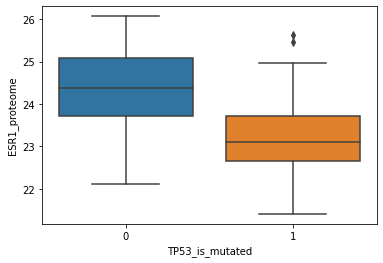

In [380]:
p = combined.copy()
p = p[p['disease']=='BR']
sns.boxplot(data=p, x='TP53_is_mutated', y='ESR1_proteome')

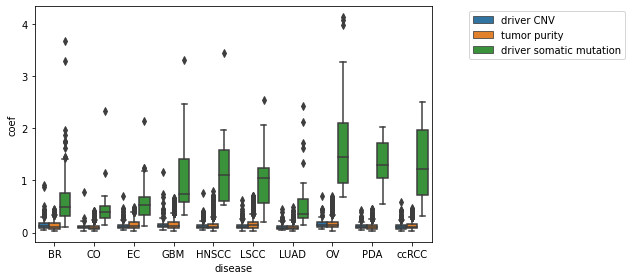

In [191]:
# plot aggregate coefficients accross cancer types
fig, axs = plt.subplots(figsize=(10, 4))
p = master_coef_df[master_coef_df['FDR']<=.05].copy()
p['coef'] = np.abs(p['coef'])
p = p[p['feature']!='driver_gene_is_pathogenic_germline']

# rename coef
p['feature'] = [rename[x] for x in p['feature']]

sns.boxplot(data=p, x='disease', y='coef', hue='feature')
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'aggregated_significant_feature_coefficients_boxplot.pdf'))

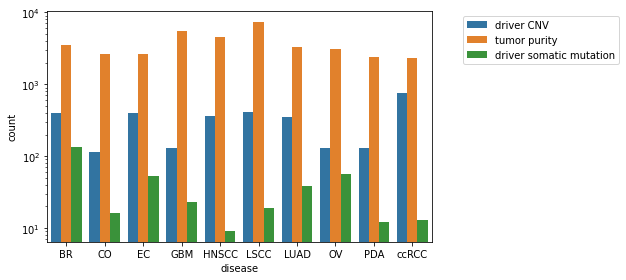

In [193]:
fig, axs = plt.subplots(figsize=(10, 4))
sns.countplot(data=p, x='disease', hue='feature')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'aggregated_significant_feature_coefficients_countplot.pdf'))

In [55]:
## export data for yize
master_coef_df.to_csv('../data/yize_export.txt', sep='\t', index=False)

In [154]:
master_coef_df

,coef,p-value,FDR,-log10(FDR),feature,driver,target,disease,model_r2,model_r2_FDR
0,-0.034324,7.216432e-02,3.615290e-01,0.441857,driver_gene_cnv,ABL1,ABI1,BR,0.005537,4.310828e-01
1,-0.009837,6.046619e-01,7.309830e-01,0.136093,TumorPurity,ABL1,ABI1,BR,0.005537,4.310828e-01
2,0.069500,6.370391e-01,9.757770e-01,0.010649,driver_gene_is_mutated,ABL1,ABI1,BR,0.005537,4.310828e-01
3,0.000000,NaN,NaN,NaN,driver_gene_is_pathogenic_germline,ABL1,ABI1,BR,0.005537,4.310828e-01
4,0.179461,7.645052e-11,5.102308e-08,7.292233,driver_gene_cnv,ABL1,ABL1,BR,0.292508,9.747623e-08
...,...,...,...,...,...,...,...,...,...,...
378847,0.000000,NaN,NaN,NaN,driver_gene_is_pathogenic_germline,ZNF750,ZNF706,ccRCC,0.009613,3.984553e-01
378848,0.067997,1.683222e-01,3.237714e-01,0.489761,TumorPurity,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01
378849,-0.003108,9.495019e-01,9.797429e-01,0.008888,driver_gene_cnv,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01
378850,0.828135,1.080325e-01,9.530489e-01,0.020885,driver_gene_is_mutated,ZNF750,ZNF740,ccRCC,0.012605,3.618946e-01


In [336]:
# # make volcano plot for each feature and disease
# for disease, results in results_dict.items():
#     for driver in target_genes:
#         keys = [k for k in results.keys() if driver==k.split('_')[0]]
#         df = None
#         for key in keys:
#             coef_df = results[key]['coef_df']
#             if df is None:
#                 df = coef_df.copy()

In [221]:
X, y = get_data_for_pair('PIK3CA', 'TP53', combined)
X

,PIK3CA_cnv,TP53_cnv,TumorPurity,PIK3CA_is_mutated,TP53_is_mutated,PIK3CA_is_pathogenic_germline,TP53_is_pathogenic_germline
sample_id,,,,,,,
01BR001-T,-0.712174,1.723879,1.042264,0.0,1.0,0.0,0.0
01BR008-T,-0.796036,0.426735,-0.855420,0.0,1.0,0.0,0.0
01BR009-T,-0.257153,2.395772,-0.571702,0.0,0.0,0.0,0.0
01BR010-T,-0.513522,-0.229431,0.615046,1.0,0.0,0.0,0.0
01BR015-T,-0.150468,-0.470343,0.004267,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
C3N-04119-T,-0.452007,-0.247150,-0.729195,0.0,1.0,0.0,0.0
C3N-04126-T,-0.354343,-0.529534,-1.140111,0.0,1.0,0.0,0.0
C3N-04282-T,0.155512,-1.031555,-0.271271,0.0,0.0,0.0,0.0


In [222]:
y

,TP53_proteome
sample_id,
01BR001-T,24.567060
01BR008-T,24.501803
01BR009-T,24.686889
01BR010-T,22.699751
01BR015-T,22.767829
...,...
C3N-04119-T,21.011950
C3N-04126-T,20.590258
C3N-04282-T,20.423161


In [223]:
res = run_ols(X.copy(), y.copy())

In [224]:
r = res['result']

In [225]:
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TP53_proteome   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     28.03
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           3.48e-35
Time:                        12:58:48   Log-Likelihood:                -1525.5
No. Observations:                 956   AIC:                             3067.
Df Residuals:                     948   BIC:                             3106.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        20.8394      0.073    285.619      0.000      20.696      20.983
PIK3CA_cnv                        0.2514      0.041      6.201      0.000       0.172       0.331
TP53_cnv                          0.0936      0.039      2.413      0.016       0.017       0.170
TumorPurity                      -0.0077      0.040     -0.194      0.846      -0.086       0.070
PIK3CA_is_mutated                 0.4337      0.107      4.042      0.000       0.223       0.644
TP53_is_mutated                   0.8426      0.090      9.390      0.000       0.666       1.019
PIK3CA_is_pathogenic_germline     2.6944      1.202      2.241      0.025       0.335       5.053
TP53_is_pathogenic_germline       0.0933      0.696      0.134      0.893      -1.272       1.459
==============================================================================
Omnibus:                       23.888   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.012
Skew:                           0.384   Prob(JB):                     3.70e-06
Kurtosis:                       3.197   Cond. No.                         39.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [227]:
r.pvalues

Intercept                        0.000000e+00
PIK3CA_cnv                       8.372689e-10
TP53_cnv                         1.600246e-02
TumorPurity                      8.460536e-01
PIK3CA_is_mutated                5.741419e-05
TP53_is_mutated                  4.314144e-20
PIK3CA_is_pathogenic_germline    2.522883e-02
TP53_is_pathogenic_germline      8.933812e-01
dtype: float64

In [229]:
r.params

Intercept                        20.839417
PIK3CA_cnv                        0.251390
TP53_cnv                          0.093608
TumorPurity                      -0.007714
PIK3CA_is_mutated                 0.433744
TP53_is_mutated                   0.842581
PIK3CA_is_pathogenic_germline     2.694354
TP53_is_pathogenic_germline       0.093283
dtype: float64

In [184]:
r.f_pvalue

3.4766846918007967e-35

In [164]:
s = r.summary()

In [167]:
s.tables

[<class 'statsmodels.iolib.table.SimpleTable'>,
 <class 'statsmodels.iolib.table.SimpleTable'>,
 <class 'statsmodels.iolib.table.SimpleTable'>]

In [182]:
f = open('temp.txt', 'w')
f.write(s.tables[1].as_csv())
f.close()
pd.read_csv('temp.txt', index_col=0)

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,20.8394,0.073,285.619,0.000,20.696,20.983
PIK3CA_cnv,0.2514,0.041,6.201,0.000,0.172,0.331
TP53_cnv,0.0936,0.039,2.413,0.016,0.017,0.170
TumorPurity,-0.0077,0.040,-0.194,0.846,-0.086,0.070
PIK3CA_is_mutated,0.4337,0.107,4.042,0.000,0.223,0.644
TP53_is_mutated,0.8426,0.090,9.390,0.000,0.666,1.019
PIK3CA_is_pathogenic_germline,2.6944,1.202,2.241,0.025,0.335,5.053
TP53_is_pathogenic_germline,0.0933,0.696,0.134,0.893,-1.272,1.459


In [185]:
r.fittedvalues

sample_id
01BR001-T      21.656294
01BR008-T      21.528428
01BR009-T      21.003445
01BR010-T      21.117846
01BR015-T      22.033855
                 ...    
C3N-04119-T    21.550858
C3N-04126-T    21.552147
C3N-04282-T    20.784043
C3N-04283-T    21.530103
C3N-04284-T    20.734559
Length: 956, dtype: float64

In [186]:
y

,TP53_proteome
sample_id,
01BR001-T,24.567060
01BR008-T,24.501803
01BR009-T,24.686889
01BR010-T,22.699751
01BR015-T,22.767829
...,...
C3N-04119-T,21.011950
C3N-04126-T,20.590258
C3N-04282-T,20.423161


In [175]:
r.params

Intercept                        20.839417
PIK3CA_cnv                        0.251390
TP53_cnv                          0.093608
TumorPurity                      -0.007714
PIK3CA_is_mutated                 0.433744
TP53_is_mutated                   0.842581
PIK3CA_is_pathogenic_germline     2.694354
TP53_is_pathogenic_germline       0.093283
dtype: float64

In [176]:
Counter(X['PIK3CA_is_pathogenic_germline'])

Counter({0.0: 1065, 1.0: 1})

In [81]:
target_gene = 'PIK3CA'

In [86]:
features = [f'{target_gene}_is_mutated', 'TumorPurity', f'{target_gene}_cnv', 'disease']

In [96]:
X = combined[features].copy()
y = combined[[target_gene]].copy()
X.shape, y.shape

((1255, 4), (1255, 1))

In [97]:
from collections import Counter
Counter(X['disease'])

Counter({'BR': 120,
         nan: 185,
         'ccRCC': 110,
         'CO': 96,
         'GBM': 99,
         'HNSCC': 110,
         'LUAD': 110,
         'OV': 82,
         'EC': 95,
         'LSCC': 108,
         'PDA': 140})

In [98]:
data = []
for disease in sorted(set([x for x in combined['disease'] if not pd.isnull(x)])):
    ids = combined[combined['disease']==disease].index.to_list()
    f = X.loc[ids]
    for c in X.columns:
        count = np.count_nonzero(~pd.isnull(f[c]))
#         print(counts.keys())
        data.append([disease, c, count, f.shape[0]])
stats = pd.DataFrame(data=data, columns=['disease', 'feature', 'present', 'total'])
stats

,disease,feature,present,total
0,BR,PIK3CA_is_mutated,120,120
1,BR,TumorPurity,119,120
2,BR,PIK3CA_cnv,120,120
3,BR,disease,120,120
4,CO,PIK3CA_is_mutated,96,96
5,CO,TumorPurity,96,96
6,CO,PIK3CA_cnv,96,96
7,CO,disease,96,96
8,EC,PIK3CA_is_mutated,95,95
9,EC,TumorPurity,95,95


In [99]:
X = X[[c for c in X.columns if c!='disease']]

In [103]:
X = X.dropna()


to_scale = ['TumorPurity', f'{target_gene}_cnv']
prev = X[[c for c in X.columns if c not in to_scale]]
scale = X[[c for c in X.columns if c in to_scale]]
scale = pd.DataFrame(data=StandardScaler().fit_transform(scale.values), columns=scale.columns, index=scale.index)
X = pd.merge(scale, prev, left_index=True, right_index=True)
y = y.loc[X.index]

X

,TumorPurity,PIK3CA_cnv,PIK3CA_is_mutated
sample_id,,,
01BR001-T,1.042264,-0.712173,0
01BR008-T,-0.855420,-0.796036,0
01BR009-T,-0.571702,-0.257153,0
01BR010-T,0.615046,-0.513522,1
01BR015-T,0.004267,-0.150468,1
...,...,...,...
C3N-04119-T,-0.729195,-0.452007,0
C3N-04126-T,-1.140111,-0.354343,0
C3N-04282-T,-0.271271,0.155512,0


In [104]:
Counter(combined.loc[X.index, 'disease']).most_common()

[('PDA', 139),
 ('BR', 119),
 ('ccRCC', 110),
 ('HNSCC', 110),
 ('LUAD', 110),
 ('LSCC', 108),
 ('GBM', 97),
 ('CO', 96),
 ('EC', 95),
 ('OV', 82)]

In [302]:
# model = xgb.XGBRegressor().fit(X, y)

In [303]:
# model.score(X, y)

In [304]:
# preds = model.predict(X)
# import matplotlib.pyplot as plt
# plt.scatter(preds, y)

In [305]:
# explainer = shap.Explainer(model)

In [306]:
# shap_values = explainer(X)

In [307]:
# shap.plots.waterfall(shap_values[0])

In [308]:
# shap.plots.beeswarm(shap_values, )

<AxesSubplot:xlabel='TumorPurity', ylabel='PIK3CA'>

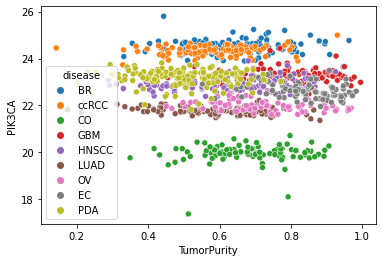

In [309]:
import seaborn as sns
sns.scatterplot(data=combined, x = 'TumorPurity', y = target_gene, hue='disease')

<AxesSubplot:xlabel='disease', ylabel='PIK3CA'>

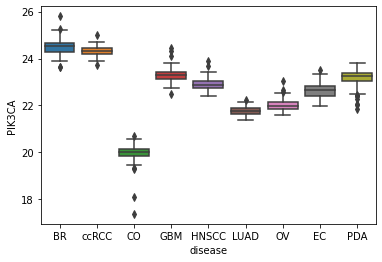

In [310]:
sns.boxplot(data=combined, x='disease', y=target_gene)

<AxesSubplot:xlabel='is_mutated', ylabel='count'>

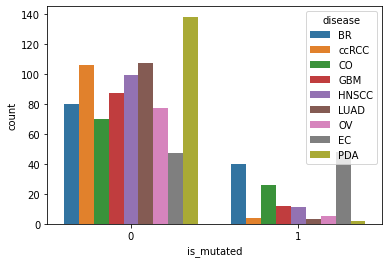

In [311]:
# target gene mutations
sns.countplot(data=combined, x='is_mutated', hue='disease')

<AxesSubplot:xlabel='is_mutated', ylabel='PIK3CA'>

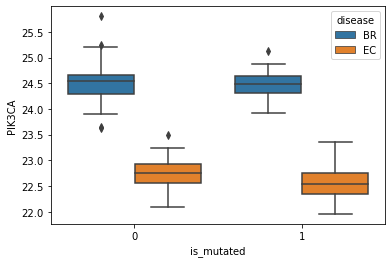

In [312]:
# target gene mutations
sns.boxplot(data=combined[[True if c in ['BR', 'EC'] else False
                          for c in combined['disease']]], x='is_mutated', y=target_gene, hue='disease')

<AxesSubplot:xlabel='TumorPurity', ylabel='PIK3CA'>

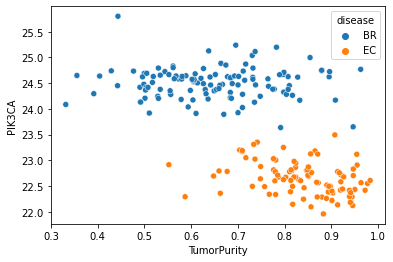

In [313]:
# target gene mutations
sns.scatterplot(data=combined[[True if c in ['BR', 'EC'] else False
                          for c in combined['disease']]], x='TumorPurity', y=target_gene, hue='disease')

<AxesSubplot:xlabel='PIK3CA_cnv', ylabel='PIK3CA'>

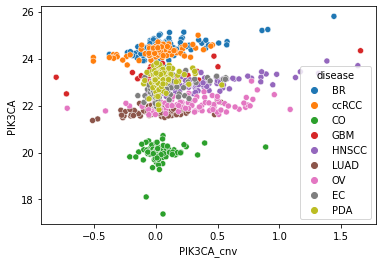

In [314]:
# target gene mutations
sns.scatterplot(data=combined, x=f'{target_gene}_cnv', y=target_gene, hue='disease')

In [315]:
# shap.plots.bar(shap_values)

In [316]:
# def pipeline_run(X, y):
    
#     print(Counter(X['is_mutated']))
    
#     idxs = np.random.choice(X.index, size=int(.7 * X.shape[0]), replace=False)
    
#     X_train, X_val = X.loc[idxs], X.loc[[x for x in X.index if x not in idxs]]
#     y_train, y_val = y.loc[X_train.index], y.loc[X_val.index]
    
#     model = xgb.XGBRegressor(n_estimators=100, max_depth=3).fit(X_train, y_train)
#     s = model.score(X_val, y_val)
#     print(f'model score: {s}')
#     preds = model.predict(X_val)
    
#     d = pd.DataFrame.from_dict({'groundtruth': y_val.values.flatten(), 'predicted': preds})
#     sns.regplot(data=d, x='groundtruth', y='predicted')
#     plt.show()
    
#     explainer = shap.Explainer(model)
#     shap_values = explainer(X)
    
#     shap.plots.beeswarm(shap_values, )
#     plt.show()
    
#     shap.plots.bar(shap_values)
#     plt.show()
    
#     return {'shap': shap_values, 'groundtruth': y_val.values.flatten(), 'prediction': preds}

In [317]:
# def plot_runs(run_dict, figsize=(10, 10)):
#     fig, axs = plt.subplots(nrows=len(run_dict), ncols=3, figsize=figsize)
#     for i, (name, run) in enumerate(run_dict.items()):
#         shap_values, groundtruth, preds = run['shap'], run['groundtruth'], run['prediction']
    
#         d = pd.DataFrame.from_dict({'groundtruth': groundtruth, 'predicted': preds})
#         sns.regplot(data=d, x='groundtruth', y='predicted', ax=axs[i, 0])

#         shap.plots.beeswarm(shap_values, ax=axs[i, 1])

#         shap.plots.bar(shap_values, ax=axs[i, 2])
        
#         axs[i, 0].set_xlabel(name, rotation=0, padding=20)
#     return fig, axs

In [318]:
# runs = {}
# for d in sorted(set([x for x in combined['disease'] if not pd.isnull(x)])):
#     common = list(set(X.index).intersection(set(combined[combined['disease']==d].index)))
#     X_filtered = X.loc[common]
#     y_filtered = y.loc[X_filtered.index]
    
#     print(d, X_filtered.shape)
#     results = pipeline_run(X_filtered, y_filtered)
#     runs[d] = results

In [319]:
from sklearn.linear_model import ElasticNet, LinearRegression
from scipy.stats import pearsonr

In [320]:
# def lg_run(X, y, ax1, ax2):
    
# #     print(Counter(X['is_mutated']))
    
# #     idxs = np.random.choice(X.index, size=int(.7 * X.shape[0]), replace=False)
    
# #     X_train, X_val = X.loc[idxs], X.loc[[x for x in X.index if x not in idxs]]
# #     y_train, y_val = y.loc[X_train.index], y.loc[X_val.index]
# #     y_train = y[~pd.isnull(y.iloc[:, 0])]
# #     X_train = X[y_train.index]
    
    
    
    
# #     model = ElasticNet().fit(X_train, y_train)
#     model = LinearRegression().fit(X, y)
#     s = model.score(X, y)
#     print(f'model score: {s}')
#     preds = model.predict(X).flatten()
    
#     c, p = pearsonr(y.values.flatten(), preds)
    
#     d = pd.DataFrame.from_dict({'groundtruth': y.values.flatten(), 'predicted': preds})
#     sns.regplot(data=d, x='groundtruth', y='predicted', ax=ax1)
# #     plt.show()
    
#     d = pd.DataFrame({'coef': model.coef_.flatten(), 'feature': X.columns})
#     sns.barplot(data=d, x='feature', y='coef', ax=ax2)
#     plt.xticks(rotation=90)
    
#     # calculate p value
#     return {'p-value': p, 'coef': c, 'y': y.values.flatten(), 'predictions': preds,
#            'model_coef': model.coef_}


def lg_run_simple(X, y):
    model = LinearRegression().fit(X, y)
    s = model.score(X, y)
    preds = model.predict(X).flatten()
    c, p = pearsonr(y.values.flatten(), preds)

    return {'p-value': p, 'coef': c, 'y': y.values.flatten(), 'predictions': preds,
           'model_coef': model.coef_, 'model_coef_order': X.columns}


In [321]:
# import matplotlib.pyplot as plt
# diseases = sorted(set([x for x in combined['disease'] if not pd.isnull(x)]))
# fig, axs = plt.subplots(ncols=len(diseases), nrows=2, figsize=(20, 4))
# for i, d in enumerate(diseases):
#     common = list(set(X.index).intersection(set(combined[combined['disease']==d].index)))
#     X_filtered = X.loc[common]
#     y_filtered = y.loc[X_filtered.index]
    
#     print(d, X_filtered.shape)
#     ax1 = axs[0, i]
#     ax2 = axs[1, i]
#     c, p = lg_run(X_filtered, y_filtered, ax1, ax2)
#     p = round(p, 5)
    
#     ax1.set_title(f'{d}, p-value: {p}')
    
#     for ax in [ax1, ax2]:
# #         ax.set_yticklabels([])
# #         ax.set_yticks([])
#         ax.set_ylabel('')
# #         ax.set_xticklabels(ax.get_xticks(), rotation = 90)
# #         ax.set_xticks([])
#         ax.set_xlabel('')

    
# plt.subplots_adjust(hspace=.2, wspace=.2)
# plt.tight_layout()

In [322]:
combined.columns

Index(['PIK3CA', 'AKT1', 'ANGPT1', 'AREG', 'AXL', 'BAG4', 'BCR', 'BDNF', 'BTC',
       'BTK',
       ...
       'mutation_is_Frame_Shift_Ins', 'mutation_is_In_Frame_Del',
       'mutation_is_In_Frame_Ins', 'mutation_is_Missense_Mutation',
       'mutation_is_Nonsense_Mutation', 'mutation_is_Nonstop_Mutation',
       'is_mutated', 'TumorPurity', 'PIK3CA_cnv', 'disease'],
      dtype='object', length=171)

In [323]:
# target = 'HCK'
# diseases = sorted(set([x for x in combined['disease'] if not pd.isnull(x)]))
# fig, axs = plt.subplots(ncols=len(diseases), nrows=2, figsize=(20, 4))
# for i, d in enumerate(diseases):
# #     common = list(set(X.index).intersection(set(combined[combined['disease']==d].index)))
    
# #     X_filtered = X.loc[common]
# #     y_filtered = y.loc[X_filtered.index]
    
#     y = combined[[target]]
#     y = y[~pd.isnull(y.values.flatten())]
#     common = list(set(y.index).intersection(set(combined[combined['disease']==d].index)))
#     common = set(common).intersection(set(X.index))
    
#     X_filtered = X.loc[common]
#     y_filtered = y.loc[X_filtered.index]
    
    
#     print(d, X_filtered.shape)
#     ax1 = axs[0, i]
#     ax2 = axs[1, i]
#     c, p = lg_run(X_filtered, y_filtered, ax1, ax2)
#     p = round(p, 5)
    
#     ax1.set_title(f'{d}, p-value: {p}')
    
#     for ax in [ax1, ax2]:
# #         ax.set_yticklabels([])
# #         ax.set_yticks([])
#         ax.set_ylabel('')
# #         ax.set_xticklabels(ax.get_xticks(), rotation = 90)
# #         ax.set_xticks([])
#         ax.set_xlabel('')

    
# plt.subplots_adjust(hspace=.2, wspace=.2)
# plt.tight_layout()

In [324]:
diseases = sorted(set([x for x in combined['disease'] if not pd.isnull(x)]))
targets = [target_gene] + [g for g in subgenes if g in combined.columns]
result_dict = {}
for target in targets:
    result_dict[target] = {}
    for i, d in enumerate(diseases):
        y = combined[[target]]
        y = y[~pd.isnull(y.values.flatten())]
        common = list(set(y.index).intersection(set(combined[combined['disease']==d].index)))
        common = set(common).intersection(set(X.index))

        X_filtered = X.loc[common]
        y_filtered = y.loc[X_filtered.index]
        
        if X_filtered.shape[0]:
            result = lg_run_simple(X_filtered, y_filtered)
            result_dict[target][d] = result


In [325]:
result_dict[target_gene]

{'BR': {'p-value': 2.686105865143571e-10,
  'coef': 0.5384321769336753,
  'y': array([24.5944824 , 24.73445681, 25.1987954 , 24.24488975, 24.28394794,
         24.63811102, 24.35105513, 24.66805697, 24.69250231, 24.38260232,
         24.37965221, 23.65150707, 24.37810975, 24.88491564, 24.73946124,
         24.38458934, 24.02603316, 24.57999527, 25.23872027, 24.41994473,
         24.71066922, 24.20542912, 24.75108602, 24.18339876, 24.47772611,
         24.62213846, 24.60384669, 24.17338989, 23.91158177, 24.16820503,
         24.83291611, 24.61948958, 24.66380691, 23.92607366, 24.99733839,
         24.46393114, 24.394615  , 24.49214281, 24.64880707, 24.12949535,
         25.11424098, 24.50480093, 24.51437597, 24.74128538, 24.16995596,
         24.58544299, 25.12671025, 24.62532174, 24.78408488, 24.58210446,
         24.6896163 , 24.61694225, 24.45039121, 24.26415184, 24.57462235,
         24.216003  , 24.19217507, 24.45170778, 23.91861567, 24.66707957,
         24.54634118, 24.7246279 , 

In [326]:
# adjust the p-values
from statsmodels.stats.multitest import fdrcorrection
target_gene_to_p = {f'{t}_{g}':m['p-value'] for t, d in result_dict.items() for g, m in d.items()}
tups = list(target_gene_to_p.items())
ps = [p for _, p in tups]
corrected = fdrcorrection(ps)[1]
target_gene_to_p = {k:p for k, p in zip([k for k, _ in tups], corrected)}
for t, d in result_dict.items():
    for g, m in d.items():
        m['corrected_p-value'] = target_gene_to_p[f'{t}_{g}']

In [327]:
result_dict[target_gene]

{'BR': {'p-value': 2.686105865143571e-10,
  'coef': 0.5384321769336753,
  'y': array([24.5944824 , 24.73445681, 25.1987954 , 24.24488975, 24.28394794,
         24.63811102, 24.35105513, 24.66805697, 24.69250231, 24.38260232,
         24.37965221, 23.65150707, 24.37810975, 24.88491564, 24.73946124,
         24.38458934, 24.02603316, 24.57999527, 25.23872027, 24.41994473,
         24.71066922, 24.20542912, 24.75108602, 24.18339876, 24.47772611,
         24.62213846, 24.60384669, 24.17338989, 23.91158177, 24.16820503,
         24.83291611, 24.61948958, 24.66380691, 23.92607366, 24.99733839,
         24.46393114, 24.394615  , 24.49214281, 24.64880707, 24.12949535,
         25.11424098, 24.50480093, 24.51437597, 24.74128538, 24.16995596,
         24.58544299, 25.12671025, 24.62532174, 24.78408488, 24.58210446,
         24.6896163 , 24.61694225, 24.45039121, 24.26415184, 24.57462235,
         24.216003  , 24.19217507, 24.45170778, 23.91861567, 24.66707957,
         24.54634118, 24.7246279 , 

In [328]:
import matplotlib.pyplot as plt
def plot_scatter_feature(result, figsize=(20, 4)):
    diseases = sorted(result.keys())
    fig, axs = plt.subplots(ncols=len(diseases), nrows=2, figsize=figsize)
    for i, disease in enumerate(diseases):
        r = result[disease]
        p_value, x, y, coefs, order = round(r['corrected_p-value'], 5), r['y'], r['predictions'], r['model_coef'], r['model_coef_order']
        
        ax1 = axs[0, i]
        ax2 = axs[1, i]
        
        d = pd.DataFrame.from_dict({'groundtruth': x, 'predicted': y})
        sns.regplot(data=d, x='groundtruth', y='predicted', ax=ax1)
        
    
        ax1.set_title(f'{disease}, p-value: {p_value}')
        
        d = pd.DataFrame({'coef': coefs.flatten(), 'feature': order})
        sns.barplot(data=d, x='feature', y='coef', ax=ax2)
        plt.xticks(rotation=90)
        

        for ax in [ax1, ax2]:
            ax.set_ylabel('')
            ax.set_xlabel('') 
        if len(diseases) - i != 1:
            ax2.set_xticks([])
        
    plt.subplots_adjust(hspace=.2, wspace=.2)
    plt.tight_layout()

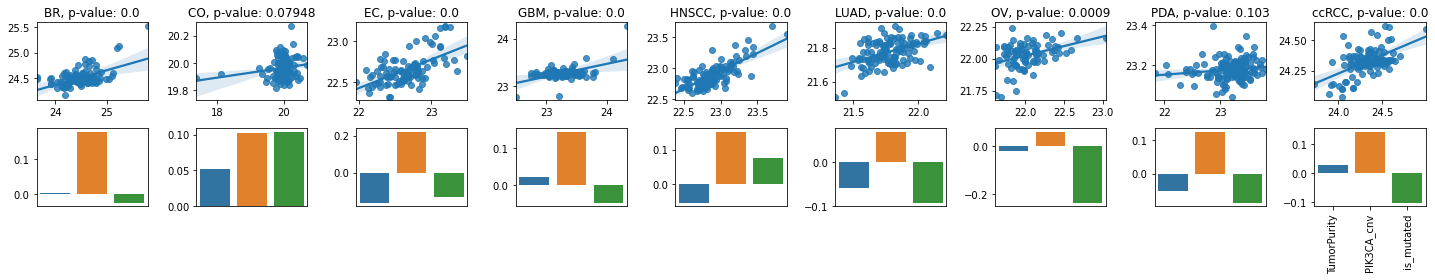

In [329]:
plot_scatter_feature(result_dict[target_gene])

In [330]:
data, idxs = [], []
for t, d in result_dict.items():
    for g, m in d.items():
#         print(t, g, m['corrected_p-value'])
        data.append([t, g, m['coef'], m['p-value'], m['corrected_p-value'], m['model_coef'].flatten()[0],
                    m['model_coef'].flatten()[1], m['model_coef'].flatten()[2]])
df = pd.DataFrame(data=data, columns=['target gene', 'disease', 'pearson coef', 'p-value', 'FDR',
                                      m['model_coef_order'][0], m['model_coef_order'][1], 
                                      m['model_coef_order'][2]])
df

,target gene,disease,pearson coef,p-value,FDR,TumorPurity,PIK3CA_cnv,is_mutated
0,PIK3CA,BR,0.538432,2.686106e-10,3.229502e-09,0.002812,0.177148,-0.025270
1,PIK3CA,CO,0.190783,6.261204e-02,7.948081e-02,0.051848,0.102296,0.103730
2,PIK3CA,EC,0.592357,2.563139e-10,3.127875e-09,-0.161107,0.220387,-0.130772
3,PIK3CA,GBM,0.517391,5.748115e-08,4.199182e-07,0.022023,0.143309,-0.047928
4,PIK3CA,HNSCC,0.760090,6.054126e-22,5.756923e-20,-0.052515,0.151530,0.075353
...,...,...,...,...,...,...,...,...
1041,ZMYM2,HNSCC,0.509934,1.269325e-08,1.134799e-07,0.052866,0.097898,0.147334
1042,ZMYM2,LUAD,0.398409,1.627508e-05,6.399899e-05,0.130534,0.041659,-0.065735
1043,ZMYM2,OV,0.453043,1.921391e-05,7.443612e-05,0.163235,0.025726,0.044288
1044,ZMYM2,PDA,0.227001,7.203002e-03,1.243291e-02,0.040438,0.071961,0.246269


In [331]:
df.to_csv(f'../data/{target_gene}.txt', sep='\t', index=False)

In [332]:
df

,target gene,disease,pearson coef,p-value,FDR,TumorPurity,PIK3CA_cnv,is_mutated
0,PIK3CA,BR,0.538432,2.686106e-10,3.229502e-09,0.002812,0.177148,-0.025270
1,PIK3CA,CO,0.190783,6.261204e-02,7.948081e-02,0.051848,0.102296,0.103730
2,PIK3CA,EC,0.592357,2.563139e-10,3.127875e-09,-0.161107,0.220387,-0.130772
3,PIK3CA,GBM,0.517391,5.748115e-08,4.199182e-07,0.022023,0.143309,-0.047928
4,PIK3CA,HNSCC,0.760090,6.054126e-22,5.756923e-20,-0.052515,0.151530,0.075353
...,...,...,...,...,...,...,...,...
1041,ZMYM2,HNSCC,0.509934,1.269325e-08,1.134799e-07,0.052866,0.097898,0.147334
1042,ZMYM2,LUAD,0.398409,1.627508e-05,6.399899e-05,0.130534,0.041659,-0.065735
1043,ZMYM2,OV,0.453043,1.921391e-05,7.443612e-05,0.163235,0.025726,0.044288
1044,ZMYM2,PDA,0.227001,7.203002e-03,1.243291e-02,0.040438,0.071961,0.246269


In [333]:
data = []
for i, r in df.iterrows():
    if r['FDR'] < .05:
        data.append([r['target gene'], r['disease'], r['pearson coef'], df.columns[-3], r[df.columns[-3]]])
        data.append([r['target gene'], r['disease'], r['pearson coef'], df.columns[-2], r[df.columns[-2]]])
        data.append([r['target gene'], r['disease'], r['pearson coef'], df.columns[-1], r[df.columns[-1]]])
model_coef_df = pd.DataFrame(data=data, columns=['target gene', 'disease', 'pearson coef', 'coef type', 'coef value'])
model_coef_df

,target gene,disease,pearson coef,coef type,coef value
0,PIK3CA,BR,0.538432,TumorPurity,0.002812
1,PIK3CA,BR,0.538432,PIK3CA_cnv,0.177148
2,PIK3CA,BR,0.538432,is_mutated,-0.025270
3,PIK3CA,EC,0.592357,TumorPurity,-0.161107
4,PIK3CA,EC,0.592357,PIK3CA_cnv,0.220387
...,...,...,...,...,...
2296,ZMYM2,OV,0.453043,PIK3CA_cnv,0.025726
2297,ZMYM2,OV,0.453043,is_mutated,0.044288
2298,ZMYM2,PDA,0.227001,TumorPurity,0.040438
2299,ZMYM2,PDA,0.227001,PIK3CA_cnv,0.071961


In [334]:
sorted(set(model_coef_df['target gene']))

['AKT1',
 'ANGPT1',
 'AXL',
 'BAG4',
 'BCR',
 'BDNF',
 'BTC',
 'BTK',
 'CBL',
 'CD19',
 'CD247',
 'CD2AP',
 'CD3G',
 'CD86',
 'CDC37',
 'CNTRL',
 'CPSF6',
 'CSF2RA',
 'CUX1',
 'EGFR',
 'EIF4EBP1',
 'ERBB2',
 'ERBB3',
 'ERBB4',
 'ERLIN2',
 'ESR1',
 'FCGR1A',
 'FCGR2A',
 'FCGR3A',
 'FGF1',
 'FGF2',
 'FGF7',
 'FGFR1',
 'FGFR1OP',
 'FGFR1OP2',
 'FGFR2',
 'FGFR3',
 'FOXO3',
 'FRS2',
 'FYN',
 'GAB1',
 'GAB2',
 'GFRA1',
 'GFRA3',
 'GNA11',
 'GNA14',
 'GNA15',
 'GNAQ',
 'GRB2',
 'HCK',
 'HGF',
 'HLA-E',
 'HSP90AA1',
 'IGHG1',
 'IGHG2',
 'IGHG3',
 'IGHG4',
 'IGHV1-2',
 'IGHV1-46',
 'IGHV2-5',
 'IGHV2-70',
 'IGHV3-11',
 'IGHV3-13',
 'IGHV3-23',
 'IGHV3-30',
 'IGHV3-48',
 'IGHV3-53',
 'IGHV3-7',
 'IGHV4-34',
 'IGHV4-39',
 'IGHV7-81',
 'IGKC',
 'IGKV1-16',
 'IGKV1-17',
 'IGKV1-5',
 'IGKV1D-16',
 'IGKV2-30',
 'IGKV3-11',
 'IGKV3-20',
 'IGKV3D-20',
 'IGKV4-1',
 'IGLC7',
 'IGLV1-40',
 'IGLV1-44',
 'IGLV1-47',
 'IGLV1-51',
 'IGLV2-11',
 'IGLV2-14',
 'IGLV2-23',
 'IGLV2-8',
 'IGLV3-1',
 'IGLV3-19',
 'I

<AxesSubplot:xlabel='disease', ylabel='coef value'>

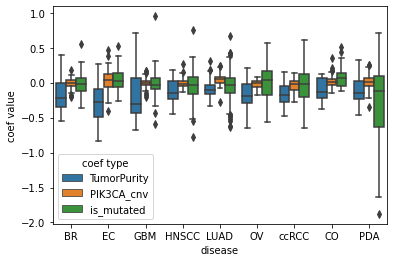

In [335]:
sns.boxplot(data=model_coef_df, x='disease', y='coef value', hue='coef type')

<AxesSubplot:xlabel='disease', ylabel='count'>

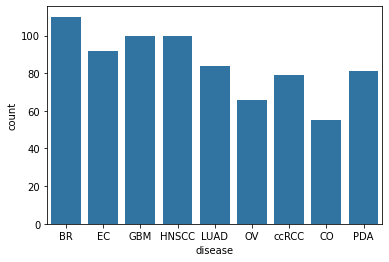

In [336]:
p = df.copy()
p['significant relationship (FDR < .05)'] = [True if x < .05 else False for x in p['FDR']]
sns.countplot(data=p[p['significant relationship (FDR < .05)']], x='disease', color=sns.color_palette()[0])

<AxesSubplot:xlabel='PIK3CA_cnv', ylabel='pearson coef'>

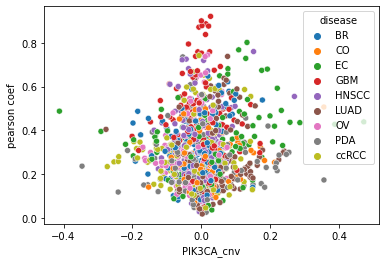

In [337]:
sns.scatterplot(data=df, x='PIK3CA_cnv', y='pearson coef', hue='disease')

<AxesSubplot:xlabel='TumorPurity', ylabel='pearson coef'>

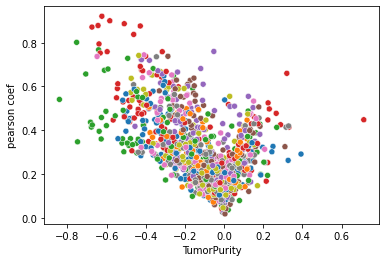

In [338]:
sns.scatterplot(data=df, x='TumorPurity', y='pearson coef', hue='disease', legend=False)

<AxesSubplot:xlabel='is_mutated', ylabel='pearson coef'>

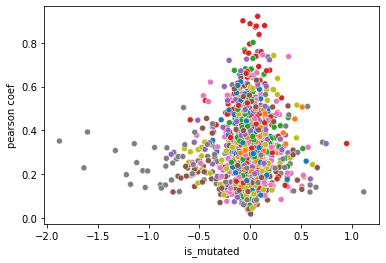

In [339]:
sns.scatterplot(data=df, x='is_mutated', y='pearson coef', hue='disease', legend=False)


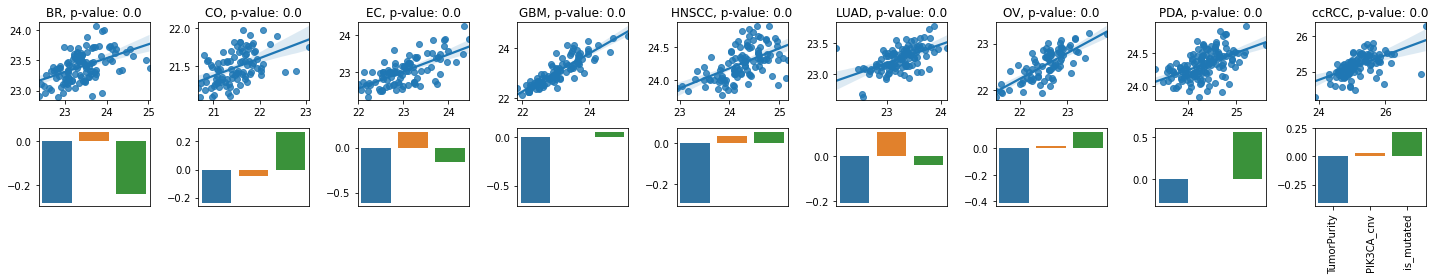

In [340]:
plot_scatter_feature(result_dict['HCK'])

In [341]:
df.sort_values('pearson coef')

,target gene,disease,pearson coef,p-value,FDR,TumorPurity,PIK3CA_cnv,is_mutated
916,RPS6KB1,LUAD,0.017190,8.585314e-01,8.585314e-01,0.004338,0.002559,0.005013
137,EIF4EBP1,PDA,0.025266,7.678105e-01,7.692814e-01,-0.008233,0.014034,-0.006316
718,KIRREL1,HNSCC,0.028197,7.699727e-01,7.707095e-01,-0.001002,-0.006174,0.004271
197,FGF1,EC,0.035736,7.309914e-01,7.330939e-01,0.020957,0.030422,-0.017803
244,FOXO3,GBM,0.037766,7.134253e-01,7.161640e-01,-0.010799,0.000519,-0.020213
...,...,...,...,...,...,...,...,...
826,PIK3CD,GBM,0.876480,6.443997e-32,1.348084e-29,-0.428210,0.020939,0.061094
809,PIK3AP1,GBM,0.878630,2.948080e-32,7.709230e-30,-0.643917,0.001763,0.142511
51,BTK,GBM,0.886957,1.232094e-33,4.295903e-31,-0.510068,0.012890,-0.000697
962,SYK,GBM,0.900425,4.111555e-36,2.150343e-33,-0.583883,0.000079,-0.071083


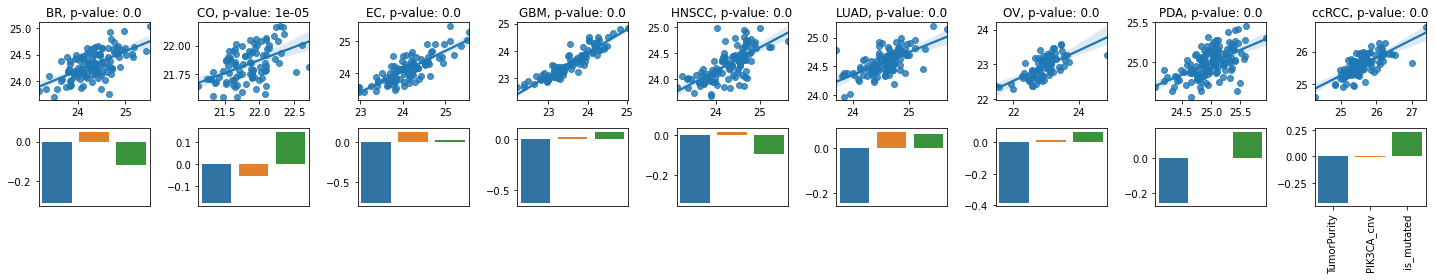

In [342]:
plot_scatter_feature(result_dict['VAV1'])

<AxesSubplot:xlabel='is_mutated', ylabel='PIK3CA'>

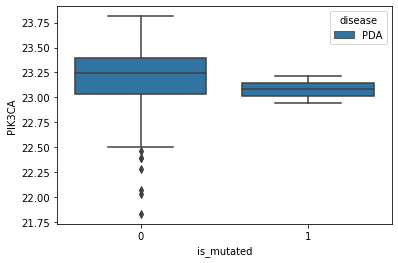

In [343]:
# target gene mutations
sns.boxplot(data=combined[[True if c in ['PDA'] else False
                          for c in combined['disease']]], x='is_mutated',
            y=target_gene, hue='disease')

<AxesSubplot:xlabel='is_mutated', ylabel='count'>

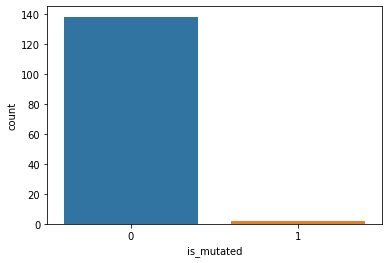

In [344]:
# target gene mutations
sns.countplot(data=combined[[True if c in ['PDA'] else False
                          for c in combined['disease']]], x='is_mutated')

<AxesSubplot:xlabel='disease', ylabel='count'>

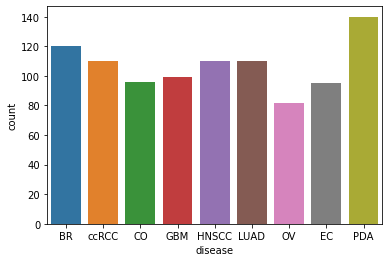

In [359]:
sns.countplot(data=combined, x='disease')

In [83]:
# now we do different mutation types

In [345]:
combined

,PIK3CA,AKT1,ANGPT1,AREG,AXL,BAG4,BCR,BDNF,BTC,BTK,...,mutation_is_Frame_Shift_Ins,mutation_is_In_Frame_Del,mutation_is_In_Frame_Ins,mutation_is_Missense_Mutation,mutation_is_Nonsense_Mutation,mutation_is_Nonstop_Mutation,is_mutated,TumorPurity,PIK3CA_cnv,disease
sample_id,,,,,,,,,,,,,,,,,,,,,
01BR001-T,24.264152,25.874492,NaN,18.739884,19.344495,23.734385,23.805945,NaN,NaN,23.199002,...,0,0,0,0,0,0,0,0.816624,-0.06602,BR
01BR008-T,23.918616,26.197705,NaN,19.550302,19.336732,23.565567,23.346108,NaN,NaN,24.575333,...,0,0,0,0,0,0,0,0.510466,-0.09075,BR
01BR009-T,24.286767,25.818366,NaN,19.450294,19.953784,23.026513,23.659390,NaN,NaN,23.418663,...,0,0,0,0,0,0,0,0.556239,0.06816,BR
01BR010-T,24.244890,26.676400,NaN,20.508779,19.917262,22.817290,23.715995,NaN,NaN,22.952537,...,0,1,0,0,0,0,1,0.747700,-0.00744,BR
01BR015-T,24.351055,26.555041,NaN,17.785048,20.308908,23.017593,23.272980,NaN,NaN,23.224693,...,0,1,0,0,0,0,1,0.649161,0.09962,BR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-04119-T,23.403281,25.921602,NaN,NaN,22.611990,22.493845,23.608573,NaN,NaN,23.408569,...,0,0,0,0,0,0,0,0.530830,0.01070,PDA
C3N-04126-T,23.329643,25.755854,NaN,NaN,22.790398,22.411983,23.792508,NaN,NaN,23.888502,...,0,0,0,0,0,0,0,0.464536,0.03950,PDA
C3N-04282-T,23.449377,26.000939,NaN,NaN,23.148284,22.616522,23.880693,NaN,NaN,23.435737,...,0,0,0,0,0,0,0,0.604708,0.18985,PDA


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'In_Frame_Del'),
  Text(1, 0, 'Missense_Mutation'),
  Text(2, 0, 'Frame_Shift_Ins'),
  Text(3, 0, 'Frame_Shift_Del'),
  Text(4, 0, 'In_Frame_Ins'),
  Text(5, 0, 'Nonstop_Mutation'),
  Text(6, 0, 'Nonsense_Mutation')])

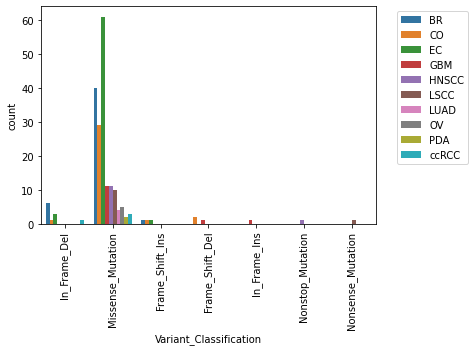

In [346]:
sns.countplot(data=mutations, x='Variant_Classification', hue='disease', )
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=90)

In [347]:
mutations

,gene,sample_id,Chromosome,Start_Position,End_Position,HGVSp_Short,Variant_Classification,disease,mutation_is_Frame_Shift_Del,mutation_is_Frame_Shift_Ins,mutation_is_In_Frame_Del,mutation_is_In_Frame_Ins,mutation_is_Missense_Mutation,mutation_is_Nonsense_Mutation,mutation_is_Nonstop_Mutation
167,PIK3CA,01BR010-T,chr3,179199160,179199162,p.L113del,In_Frame_Del,BR,0,0,1,0,0,0,0
243,PIK3CA,01BR015-T,chr3,179210189,179210194,p.H419_C420del,In_Frame_Del,BR,0,0,1,0,0,0,0
17913,PIK3CA,03BR010-T,chr3,179234302,179234302,p.G1049R,Missense_Mutation,BR,0,0,0,0,1,0,0
18111,PIK3CA,05BR004-T,chr3,179199690,179199690,p.G118D,Missense_Mutation,BR,0,0,0,0,1,0,0
18183,PIK3CA,05BR009-T,chr3,179203765,179203765,p.N345K,Missense_Mutation,BR,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,PIK3CA,C3N-01168-T,chr3,179218294,179218294,p.E542K,Missense_Mutation,PDA,0,0,0,0,1,0,0
1540,PIK3CA,C3L-00607-T,chr3,179218294,179218294,p.E542K,Missense_Mutation,ccRCC,0,0,0,0,1,0,0
3518,PIK3CA,C3L-01603-T,chr3,179210194,179210199,p.C420_L422delinsW,In_Frame_Del,ccRCC,0,0,1,0,0,0,0
4719,PIK3CA,C3N-00310-T,chr3,179234297,179234297,p.H1047R,Missense_Mutation,ccRCC,0,0,0,0,1,0,0


In [348]:
[x for x in combined.columns if 'mutation_is' in x]

['mutation_is_Frame_Shift_Del',
 'mutation_is_Frame_Shift_Ins',
 'mutation_is_In_Frame_Del',
 'mutation_is_In_Frame_Ins',
 'mutation_is_Missense_Mutation',
 'mutation_is_Nonsense_Mutation',
 'mutation_is_Nonstop_Mutation']

In [349]:
features = ['mutation_is_In_Frame_Del', 'mutation_is_Missense_Mutation',
            'TumorPurity', f'{target_gene}_cnv', 'disease']

In [350]:
X = combined[features].copy()
y = combined[[target_gene]].copy()
X.shape, y.shape

((1509, 5), (1509, 1))

In [351]:
X = X[[True if x in ['BR', 'EC'] else False for x in X['disease']]]
X = X[[c for c in X.columns if c!='disease']]
X = X.dropna()

to_scale = ['TumorPurity', 'PIK3CA_cnv']
prev = X[[c for c in X.columns if c not in to_scale]]
prev = pd.DataFrame(data=prev.values - .5, columns=prev.columns, index=prev.index)

scale = X[[c for c in X.columns if c in to_scale]]
scale = pd.DataFrame(data=StandardScaler().fit_transform(scale.values), columns=scale.columns, index=scale.index)
X = pd.merge(scale, prev, left_index=True, right_index=True)
y = y.loc[X.index]
X

,TumorPurity,PIK3CA_cnv,mutation_is_In_Frame_Del,mutation_is_Missense_Mutation
sample_id,,,,
01BR001-T,0.570620,-0.743757,-0.5,-0.5
01BR008-T,-1.505145,-0.873175,-0.5,-0.5
01BR009-T,-1.194802,-0.041560,-0.5,-0.5
01BR010-T,0.103311,-0.437193,0.5,-0.5
01BR015-T,-0.564784,0.123078,0.5,-0.5
...,...,...,...,...
C3N-01520-T,0.930270,-0.733866,-0.5,0.5
C3N-01521-T,0.834595,1.250320,-0.5,-0.5
C3N-01537-T,-0.573207,0.069752,-0.5,-0.5


In [352]:
diseases = ['BR', 'EC']
targets = [target_gene] + [g for g in subgenes if g in combined.columns]
result_dict = {}
for target in targets:
    result_dict[target] = {}
    for i, d in enumerate(diseases):
        y = combined[[target]]
        y = y[~pd.isnull(y.values.flatten())]
        common = list(set(y.index).intersection(set(combined[combined['disease']==d].index)))
        common = set(common).intersection(set(X.index))

        X_filtered = X.loc[common]
        y_filtered = y.loc[X_filtered.index]
        
        if X_filtered.shape[0]:
            result = lg_run_simple(X_filtered, y_filtered)
            result_dict[target][d] = result


In [353]:
# adjust the p-values
from statsmodels.stats.multitest import fdrcorrection
target_gene_to_p = {f'{t}_{g}':m['p-value'] for t, d in result_dict.items() for g, m in d.items()}
tups = list(target_gene_to_p.items())
ps = [p for _, p in tups]
corrected = fdrcorrection(ps)[1]
target_gene_to_p = {k:p for k, p in zip([k for k, _ in tups], corrected)}
for t, d in result_dict.items():
    for g, m in d.items():
        m['corrected_p-value'] = target_gene_to_p[f'{t}_{g}']

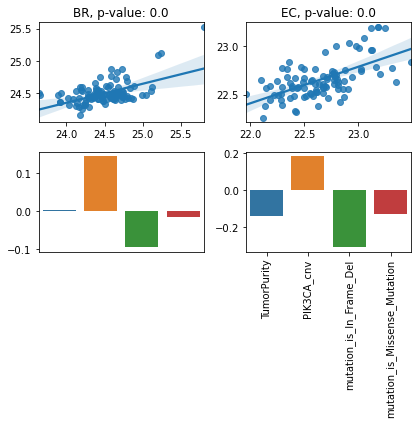

In [354]:
plot_scatter_feature(result_dict[target_gene], figsize=(6, 6))

<AxesSubplot:xlabel='TumorPurity', ylabel='PIK3CA'>

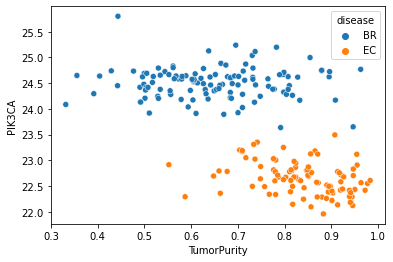

In [355]:
# target gene mutations
sns.scatterplot(data=combined[[True if c in ['BR', 'EC'] else False
                          for c in combined['disease']]], x='TumorPurity', y=target_gene, hue='disease')

<AxesSubplot:xlabel='PIK3CA_cnv', ylabel='PIK3CA'>

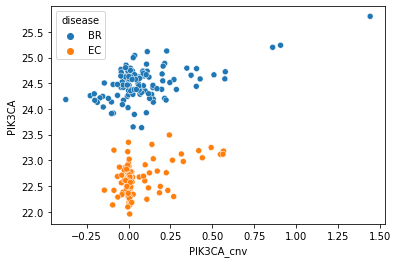

In [356]:
# target gene mutations
sns.scatterplot(data=combined[[True if c in ['BR', 'EC'] else False
                          for c in combined['disease']]], x=f'{target_gene}_cnv', y=target_gene, hue='disease')

<AxesSubplot:xlabel='mutation_is_In_Frame_Del', ylabel='PIK3CA'>

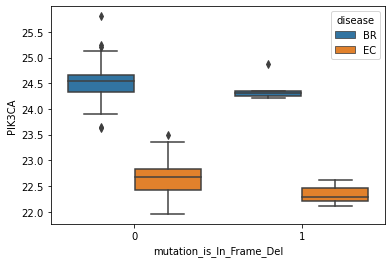

In [357]:
# target gene mutations
sns.boxplot(data=combined[[True if c in ['BR', 'EC'] else False
                          for c in combined['disease']]], x='mutation_is_In_Frame_Del',
            y=target_gene, hue='disease')

<AxesSubplot:xlabel='mutation_is_Missense_Mutation', ylabel='PIK3CA'>

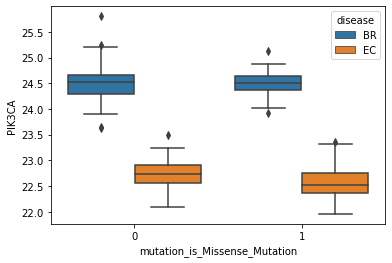

In [358]:
# target gene mutations
sns.boxplot(data=combined[[True if c in ['BR', 'EC'] else False
                          for c in combined['disease']]], x='mutation_is_Missense_Mutation',
            y=target_gene, hue='disease')